In [29]:
import copy
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)    
matplotlib.rcParams['axes.unicode_minus'] = False      
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 150)

from xgboost import XGBRegressor

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.set_printoptions(sci_mode=False)
random_seed = 616

### 기본 데이터

In [30]:
y_col = '유입량'
PK_col = ['홍수사상번호','연','월','일','시간']

In [31]:
data_raw = pd.read_excel('../data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])
data_raw = data_raw.dropna()

data_raw.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in data_raw.columns.values]

In [32]:
# 결과 값 저장할 dataframe 생성

predict_df = pd.DataFrame()
predict_df[PK_col] = data_raw[PK_col]
predict_df['true'] = data_raw.유입량

score_df = pd.DataFrame()

## source code

In [33]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layer=(1, 1, 1), batch_norm=True, drop_out=True, drop_prob=0.3):
        super().__init__()
        self.hidden_layer = self.make_layers(input_size, hidden_layer, batch_norm, drop_out, drop_prob)

    def forward(self, x):
        out = self.hidden_layer(x)
        return out

    def make_layers(self, input_size, hidden_layer, batch_norm, drop_out, drop_prob):
        layers = []
        in_size = input_size
        if hidden_layer[0] == 'R':
            for v in hidden_layer[1:]:
                out_size = int(v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size
        else:
            for v in hidden_layer:
                out_size = int(input_size * v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size

        linear = nn.Linear(out_size, 1)
        torch.nn.init.xavier_uniform_(linear.weight)
        layers += [linear]

        return nn.Sequential(*layers)

In [34]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [35]:
first_values = data_raw.groupby('홍수사상번호').first()['유입량']

def dnn_predict(name, data, model_structure, scaler, view=False, view_num=5, early_stop_num = 3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device
    pred_values = []
    predict_df = pd.DataFrame()
    predict_df[PK_col] = data[['홍수사상번호','연','월','일','시간']]
    predict_df['true'] = data.유입량
    
    for num in data.홍수사상번호.unique():
        print(f"홍수사상번호 {num} 시작")
        train = data[data['홍수사상번호'] != num].dropna().copy()
        valid = data[data['홍수사상번호'] == num].copy()

        X_train = train.drop(columns=[y_col]+PK_col)
        y_train = train[y_col]

        X_valid = valid.drop(columns=[y_col]+PK_col)
        y_valid = valid[y_col]
        
        scaler.fit(X_train)

        X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
        X_valid_tensors = torch.Tensor(scaler.transform(X_valid)).to(device)

        y_train_tensors = torch.Tensor(y_train.values).to(device)
        y_valid_tensors = torch.Tensor(y_valid.values).to(device)
        
        input_size = X_train.shape[1]

        dnn = DNN(input_size, model_structure["hidden_layer"], model_structure["batch_norm"],
                  model_structure["drop_out"], model_structure["drop_prob"]).to(device)
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(dnn.parameters(), lr=model_structure["learning_rate"])  # adam optimizer
        
        best_loss = 1E+10
        best_epoch = 0
        for epoch in range(model_structure["num_epochs"]):
            optimizer.zero_grad()
            outputs = dnn(X_train_tensors)
            loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                dnn.eval()
                outputs_valid = dnn(X_valid_tensors)
                loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
                if loss_valid < best_loss:
                    best_loss = loss_valid
                    best_epoch = epoch
                    pred_valid = list(outputs_valid.view(-1).detach().cpu().numpy())
                dnn.train()

            if view and ((epoch+1) % (model_structure["num_epochs"]//view_num) == 0):
                print("  Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))
            
            if (epoch - best_epoch) > (model_structure["num_epochs"] // early_stop_num):
                print("Best Epoch: %d Best Valid Loss: %1.2f" % (best_epoch+1, best_loss.item()))
                break
        print("")
        pred_values += pred_valid
    
    predict_df[f'pred_{name}'] = pred_values
    
    return predict_df

In [36]:
def plot_hongsunum(predict_df, names = None):
    if names == None :
        pred_names = ['true'] + list(predict_df.filter(regex='pred_').columns)
    else:
        pred_names = ['true'] + [f"pred_{name}" for name in names]
        
    for idx in predict_df['홍수사상번호'].unique():
        predict_df.loc[predict_df['홍수사상번호'] ==idx][pred_names].plot(figsize=(20,12))
        plt.legend()
        plt.title(f"홍수사상번호 : {idx}")
        plt.show()

In [37]:
def fill_nan(predict_df):
    for num in predict_df.홍수사상번호:
        predict_num = predict_df[predict_df.홍수사상번호 == num]
        predict_num = predict_num.fillna(method='ffill').fillna(method='bfill')
        predict_df.loc[predict_df.홍수사상번호 == num] = predict_num
        
def rmse(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_error(true, pred))

def rmsle(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_log_error(true, pred))
    
def r2(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return r2_score(true, pred)

def mape(predict_df, name):
    pred = predict_df[predict_df[f'pred_{name}'].notnull()][f'pred_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.mean(np.abs((true - pred) / true))*100

## model structure

In [38]:
model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

# Predict

In [39]:
name = 'base'

data_base = data_raw.copy()

In [40]:
predict_temp = dnn_predict(name, data_base, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 1082 Best Valid Loss: 1353190.12

홍수사상번호 2 시작
Best Epoch: 616 Best Valid Loss: 867473.88

홍수사상번호 3 시작
Best Epoch: 461 Best Valid Loss: 46414.10

홍수사상번호 4 시작
Best Epoch: 592 Best Valid Loss: 182380.14

홍수사상번호 5 시작
Best Epoch: 957 Best Valid Loss: 1062583.62

홍수사상번호 6 시작
Best Epoch: 557 Best Valid Loss: 57818.68

홍수사상번호 7 시작
Best Epoch: 699 Best Valid Loss: 326725.53

홍수사상번호 8 시작
Best Epoch: 999 Best Valid Loss: 501276.31

홍수사상번호 9 시작
Best Epoch: 670 Best Valid Loss: 98633.25

홍수사상번호 10 시작
Best Epoch: 674 Best Valid Loss: 47729.96

홍수사상번호 11 시작
Best Epoch: 540 Best Valid Loss: 59314.25

홍수사상번호 12 시작
Best Epoch: 1055 Best Valid Loss: 56707.00

홍수사상번호 13 시작
Best Epoch: 809 Best Valid Loss: 69353.30

홍수사상번호 14 시작
Best Epoch: 943 Best Valid Loss: 206011.81

홍수사상번호 15 시작
Best Epoch: 1590 Best Valid Loss: 48035.37

홍수사상번호 16 시작
Best Epoch: 532 Best Valid Loss: 33702.10

홍수사상번호 17 시작
Best Epoch: 1247 Best Valid Loss: 208920.34

홍수사상번호 18 시작
Best Epoch: 494 Best Valid Los

In [41]:
predict_temp

홍수사상번호     연  월   일  시간   true  pred_base
0          1  2006  7  10   8 189.10      48.81
1          1  2006  7  10   9 216.95      55.17
2          1  2006  7  10  10 251.42      59.28
3          1  2006  7  10  11 302.81      81.03
4          1  2006  7  10  12 384.78     115.02
...      ...   ... ..  ..  ..    ...        ...
2886      25  2017  7  18  18 513.37     460.56
2887      25  2017  7  18  19 502.85     460.38
2888      25  2017  7  18  20 491.95     456.36
2889      25  2017  7  18  21 481.10     448.33
2890      25  2017  7  18  22 470.46     439.48

[2891 rows x 7 columns]

In [42]:
predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
fill_nan(predict_df)

In [43]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

RMSE  RMSLE  R2_score  MAPE
base 507.27   0.51      0.95 26.28

# Predict_ 21 23 제외

In [44]:
name = 'base_2123'

data_2123 = data_raw[~data_raw.홍수사상번호.isin([21,23])].copy()

In [45]:
predict_temp = dnn_predict(name, data_2123, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 991 Best Valid Loss: 1322586.62

홍수사상번호 2 시작
Best Epoch: 1111 Best Valid Loss: 890632.12

홍수사상번호 3 시작
Best Epoch: 473 Best Valid Loss: 48607.70

홍수사상번호 4 시작
Best Epoch: 552 Best Valid Loss: 166302.23

홍수사상번호 5 시작
Best Epoch: 926 Best Valid Loss: 1094431.00

홍수사상번호 6 시작
Best Epoch: 756 Best Valid Loss: 49667.73

홍수사상번호 7 시작
Best Epoch: 618 Best Valid Loss: 364721.97

홍수사상번호 8 시작
Best Epoch: 1120 Best Valid Loss: 390521.59

홍수사상번호 9 시작
Best Epoch: 808 Best Valid Loss: 43632.26

홍수사상번호 10 시작
Best Epoch: 546 Best Valid Loss: 35113.94

홍수사상번호 11 시작
Best Epoch: 816 Best Valid Loss: 53466.18

홍수사상번호 12 시작
Best Epoch: 1331 Best Valid Loss: 62638.75

홍수사상번호 13 시작
Best Epoch: 692 Best Valid Loss: 74455.52

홍수사상번호 14 시작
Best Epoch: 1365 Best Valid Loss: 211576.72

홍수사상번호 15 시작
Best Epoch: 921 Best Valid Loss: 53642.89

홍수사상번호 16 시작
Best Epoch: 501 Best Valid Loss: 17014.87

홍수사상번호 17 시작
Best Epoch: 637 Best Valid Loss: 201873.14

홍수사상번호 18 시작
Best Epoch: 553 Best Valid Los

In [46]:
predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
fill_nan(predict_df)

In [47]:
predict_df

홍수사상번호     연  월   일  시간   true  pred_base  pred_base_2123
0          1  2006  7  10   8 189.10      48.81           75.17
1          1  2006  7  10   9 216.95      55.17           86.25
2          1  2006  7  10  10 251.42      59.28           90.37
3          1  2006  7  10  11 302.81      81.03          117.04
4          1  2006  7  10  12 384.78     115.02          139.88
...      ...   ... ..  ..  ..    ...        ...             ...
2886      25  2017  7  18  18 513.37     460.56          455.18
2887      25  2017  7  18  19 502.85     460.38          469.68
2888      25  2017  7  18  20 491.95     456.36          469.91
2889      25  2017  7  18  21 481.10     448.33          462.27
2890      25  2017  7  18  22 470.46     439.48          452.95

[2891 rows x 8 columns]

In [48]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

RMSE  RMSLE  R2_score  MAPE
base      507.27   0.51      0.95 26.28
base_2123 501.96   0.47      0.95 22.39

## 모든 데이터 t-1 t+1

In [49]:
name = 't-1 t+1'

data_t = data_raw.copy()

for col in data_t.columns.difference([y_col] + PK_col):
    data_t[f'{col}_shift 1'] = data_t[col].shift()
    data_t[f'{col}_shift1 -1'] = data_t[col].shift(-1)

shift_col = data_t.filter(regex='shift').columns
data_t['홍수사상번호_shift 1'] = data_t['홍수사상번호'].shift()
data_t['홍수사상번호_shift -1'] = data_t['홍수사상번호'].shift(-1)

data_t.loc[(data_t['홍수사상번호'] != data_t['홍수사상번호_shift 1']), shift_col] = np.nan
data_t.loc[(data_t['홍수사상번호'] != data_t['홍수사상번호_shift -1']), shift_col] = np.nan

In [50]:
data_t = data_t.dropna()

In [51]:
predict_temp = dnn_predict(name, data_t, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 315 Best Valid Loss: 1136866.00

홍수사상번호 2 시작
Best Epoch: 528 Best Valid Loss: 658445.38

홍수사상번호 3 시작
Best Epoch: 249 Best Valid Loss: 37331.00

홍수사상번호 4 시작
Best Epoch: 296 Best Valid Loss: 122935.12

홍수사상번호 5 시작
Best Epoch: 782 Best Valid Loss: 869257.12

홍수사상번호 6 시작
Best Epoch: 1224 Best Valid Loss: 33139.83

홍수사상번호 7 시작
Best Epoch: 286 Best Valid Loss: 346297.72

홍수사상번호 8 시작
Best Epoch: 489 Best Valid Loss: 498003.09

홍수사상번호 9 시작
Best Epoch: 589 Best Valid Loss: 88590.12

홍수사상번호 10 시작
Best Epoch: 311 Best Valid Loss: 39007.75

홍수사상번호 11 시작
Best Epoch: 505 Best Valid Loss: 34918.54

홍수사상번호 12 시작
Best Epoch: 421 Best Valid Loss: 51706.70

홍수사상번호 13 시작
Best Epoch: 458 Best Valid Loss: 53073.77

홍수사상번호 14 시작
Best Epoch: 673 Best Valid Loss: 122081.23

홍수사상번호 15 시작
Best Epoch: 899 Best Valid Loss: 39798.39

홍수사상번호 16 시작
Best Epoch: 307 Best Valid Loss: 31387.57

홍수사상번호 17 시작
Best Epoch: 1084 Best Valid Loss: 105044.54

홍수사상번호 18 시작
Best Epoch: 1380 Best Valid Loss:

In [52]:
predict_temp

홍수사상번호     연  월   일  시간   true  pred_t-1 t+1
1          1  2006  7  10   9 216.95         94.63
2          1  2006  7  10  10 251.42        108.83
3          1  2006  7  10  11 302.81        124.08
4          1  2006  7  10  12 384.78        132.30
5          1  2006  7  10  13 512.50        154.97
...      ...   ... ..  ..  ..    ...           ...
2885      25  2017  7  18  17 522.99        469.94
2886      25  2017  7  18  18 513.37        448.40
2887      25  2017  7  18  19 502.85        441.30
2888      25  2017  7  18  20 491.95        436.63
2889      25  2017  7  18  21 481.10        429.43

[2841 rows x 7 columns]

In [53]:
predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
fill_nan(predict_df)

In [54]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

RMSE  RMSLE  R2_score  MAPE
base      507.27   0.51      0.95 26.28
base_2123 501.96   0.47      0.95 22.39
t-1 t+1   463.56   0.34      0.95 22.24

## 수위 E 지역만 t-1 t+1

In [55]:
name = 'waterlevel t-1 t+1'

data_waterlevel_t = data_raw.copy()

waterlevel_col = data_waterlevel_t.filter(regex='수위\(E지역\)')
for col in waterlevel_col:
    data_waterlevel_t[f'{col}_shift 1'] = data_waterlevel_t[col].shift()
    data_waterlevel_t[f'{col}_shift1 -1'] = data_waterlevel_t[col].shift(-1)

shift_col = data_waterlevel_t.filter(regex='shift').columns
data_waterlevel_t['홍수사상번호_shift 1'] = data_waterlevel_t['홍수사상번호'].shift()
data_waterlevel_t['홍수사상번호_shift -1'] = data_waterlevel_t['홍수사상번호'].shift(-1)

data_waterlevel_t.loc[(data_waterlevel_t['홍수사상번호'] != data_waterlevel_t['홍수사상번호_shift 1']), shift_col] = np.nan
data_waterlevel_t.loc[(data_waterlevel_t['홍수사상번호'] != data_waterlevel_t['홍수사상번호_shift -1']), shift_col] = np.nan

data_waterlevel_t = data_waterlevel_t.dropna()

In [56]:
predict_temp = dnn_predict(name, data_waterlevel_t, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 442 Best Valid Loss: 1831352.50

홍수사상번호 2 시작
Best Epoch: 707 Best Valid Loss: 854212.56

홍수사상번호 3 시작
Best Epoch: 372 Best Valid Loss: 44363.73

홍수사상번호 4 시작
Best Epoch: 629 Best Valid Loss: 80530.23

홍수사상번호 5 시작
Best Epoch: 1725 Best Valid Loss: 1100046.50

홍수사상번호 6 시작
Best Epoch: 436 Best Valid Loss: 72762.08

홍수사상번호 7 시작
Best Epoch: 445 Best Valid Loss: 306404.31

홍수사상번호 8 시작
Best Epoch: 625 Best Valid Loss: 438140.69

홍수사상번호 9 시작
Best Epoch: 592 Best Valid Loss: 100444.92

홍수사상번호 10 시작
Best Epoch: 433 Best Valid Loss: 45783.41

홍수사상번호 11 시작
Best Epoch: 508 Best Valid Loss: 43518.43

홍수사상번호 12 시작
Best Epoch: 755 Best Valid Loss: 65202.93

홍수사상번호 13 시작
Best Epoch: 635 Best Valid Loss: 58706.79

홍수사상번호 14 시작
Best Epoch: 1015 Best Valid Loss: 196340.92

홍수사상번호 15 시작
Best Epoch: 1634 Best Valid Loss: 52128.32

홍수사상번호 16 시작
Best Epoch: 437 Best Valid Loss: 38167.13

홍수사상번호 17 시작
Best Epoch: 1163 Best Valid Loss: 194891.12

홍수사상번호 18 시작
Best Epoch: 477 Best Valid Los

In [57]:
predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
fill_nan(predict_df)

In [58]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)
score_df

RMSE  RMSLE  R2_score  MAPE
base               507.27   0.51      0.95 26.28
base_2123          501.96   0.47      0.95 22.39
t-1 t+1            463.56   0.34      0.95 22.24
waterlevel t-1 t+1 536.74   0.43      0.94 25.45

## 클러스터링 넣기

In [59]:
for n in range(3,7):
    print('------------------')
    print(f"Clustering K : {n} Start")
    print('------------------')
    
    name = f'{n} cluster'

    data_cluster = data_raw.copy()

    clustering_df = pd.read_csv(f'../data/clustering/{n}_clustering_result.csv',index_col=0)
    cluster_list = [f'k{i}' for i in range(n)]
    
    data_cluster[cluster_list] = clustering_df
    
    predict_temp = dnn_predict(name, data_cluster, model_structure, robust_scaler, view=False, early_stop_num=10)
    
    predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
    
    score_df.loc[name, "RMSE"] = rmse(predict_df,name)
    score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
    score_df.loc[name, "R2_score"] = r2(predict_df,name)
    score_df.loc[name, "MAPE"] = mape(predict_df,name)

------------------
Clustering K : 3 Start
------------------
홍수사상번호 1 시작
Best Epoch: 791 Best Valid Loss: 1050232.00

홍수사상번호 2 시작
Best Epoch: 1030 Best Valid Loss: 965805.75

홍수사상번호 3 시작
Best Epoch: 413 Best Valid Loss: 42886.73

홍수사상번호 4 시작
Best Epoch: 503 Best Valid Loss: 180985.92

홍수사상번호 5 시작
Best Epoch: 1457 Best Valid Loss: 1065894.38

홍수사상번호 6 시작
Best Epoch: 509 Best Valid Loss: 46135.43

홍수사상번호 7 시작
Best Epoch: 492 Best Valid Loss: 328359.38

홍수사상번호 8 시작
Best Epoch: 715 Best Valid Loss: 402464.72

홍수사상번호 9 시작
Best Epoch: 764 Best Valid Loss: 129628.02

홍수사상번호 10 시작
Best Epoch: 495 Best Valid Loss: 47647.49

홍수사상번호 11 시작
Best Epoch: 554 Best Valid Loss: 66171.60

홍수사상번호 12 시작
Best Epoch: 581 Best Valid Loss: 65006.50

홍수사상번호 13 시작
Best Epoch: 689 Best Valid Loss: 68227.09

홍수사상번호 14 시작
Best Epoch: 1971 Best Valid Loss: 198941.89

홍수사상번호 15 시작
Best Epoch: 608 Best Valid Loss: 50817.05

홍수사상번호 16 시작
Best Epoch: 516 Best Valid Loss: 30791.22

홍수사상번호 17 시작
Best Epoch: 612 Best Valid

In [60]:
score_df

RMSE  RMSLE  R2_score  MAPE
base               507.27   0.51      0.95 26.28
base_2123          501.96   0.47      0.95 22.39
t-1 t+1            463.56   0.34      0.95 22.24
waterlevel t-1 t+1 536.74   0.43      0.94 25.45
3 cluster          491.36   0.42      0.95 24.72
4 cluster          486.95   0.49      0.95 27.22
5 cluster          496.49   0.49      0.95 24.32
6 cluster          496.28   0.51      0.95 24.69

## 6 clustering + t-1 t+1

In [61]:
n = 6
name = f'{n}cluster + t'

data_cluster_t = data_raw.copy()

clustering_df = pd.read_csv(f'../data/clustering/{n}_clustering_result.csv',index_col=0)
cluster_list = [f'k{i}' for i in range(n)]

data_cluster_t[cluster_list] = clustering_df

for col in data_cluster_t.columns.difference([y_col] + PK_col + cluster_list):
    data_cluster_t[f'{col}_shift 1'] = data_cluster_t[col].shift()
    data_cluster_t[f'{col}_shift1 -1'] = data_cluster_t[col].shift(-1)

shift_col = data_cluster_t.filter(regex='shift').columns
data_cluster_t['홍수사상번호_shift 1'] = data_cluster_t['홍수사상번호'].shift()
data_cluster_t['홍수사상번호_shift -1'] = data_cluster_t['홍수사상번호'].shift(-1)

data_cluster_t.loc[(data_cluster_t['홍수사상번호'] != data_cluster_t['홍수사상번호_shift 1']), shift_col] = np.nan
data_cluster_t.loc[(data_cluster_t['홍수사상번호'] != data_cluster_t['홍수사상번호_shift -1']), shift_col] = np.nan

data_cluster_t = data_cluster_t.dropna()

In [62]:
predict_temp = dnn_predict(name, data_cluster_t, model_structure, robust_scaler, view=False, early_stop_num=10)

predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')
fill_nan(predict_df)

홍수사상번호 1 시작
Best Epoch: 333 Best Valid Loss: 1055208.00

홍수사상번호 2 시작
Best Epoch: 824 Best Valid Loss: 855735.62

홍수사상번호 3 시작
Best Epoch: 223 Best Valid Loss: 43955.12

홍수사상번호 4 시작
Best Epoch: 251 Best Valid Loss: 209040.89

홍수사상번호 5 시작
Best Epoch: 698 Best Valid Loss: 1118858.25

홍수사상번호 6 시작
Best Epoch: 1743 Best Valid Loss: 23047.14

홍수사상번호 7 시작
Best Epoch: 313 Best Valid Loss: 380477.06

홍수사상번호 8 시작
Best Epoch: 505 Best Valid Loss: 372104.97

홍수사상번호 9 시작
Best Epoch: 1023 Best Valid Loss: 76994.45

홍수사상번호 10 시작
Best Epoch: 244 Best Valid Loss: 29863.10

홍수사상번호 11 시작
Best Epoch: 340 Best Valid Loss: 40197.92

홍수사상번호 12 시작
Best Epoch: 406 Best Valid Loss: 163674.42

홍수사상번호 13 시작
Best Epoch: 618 Best Valid Loss: 37183.67

홍수사상번호 14 시작
Best Epoch: 1220 Best Valid Loss: 147472.67

홍수사상번호 15 시작
Best Epoch: 1306 Best Valid Loss: 40945.39

홍수사상번호 16 시작
Best Epoch: 290 Best Valid Loss: 22321.42

홍수사상번호 17 시작
Best Epoch: 437 Best Valid Loss: 124809.38

홍수사상번호 18 시작
Best Epoch: 1606 Best Valid L

In [63]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [64]:
score_df

RMSE  RMSLE  R2_score  MAPE
base               507.27   0.51      0.95 26.28
base_2123          501.96   0.47      0.95 22.39
t-1 t+1            463.56   0.34      0.95 22.24
waterlevel t-1 t+1 536.74   0.43      0.94 25.45
3 cluster          491.36   0.42      0.95 24.72
4 cluster          486.95   0.49      0.95 27.22
5 cluster          496.49   0.49      0.95 24.32
6 cluster          496.28   0.51      0.95 24.69
6cluster + t       478.63   0.42      0.95 25.84

## log 변환

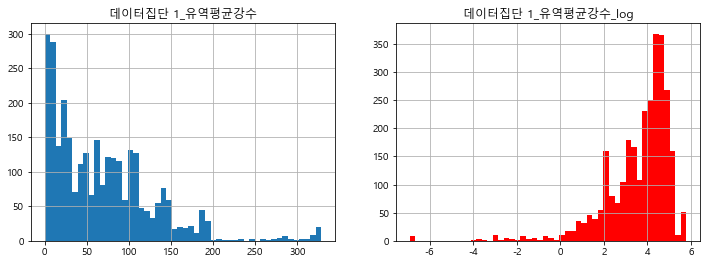

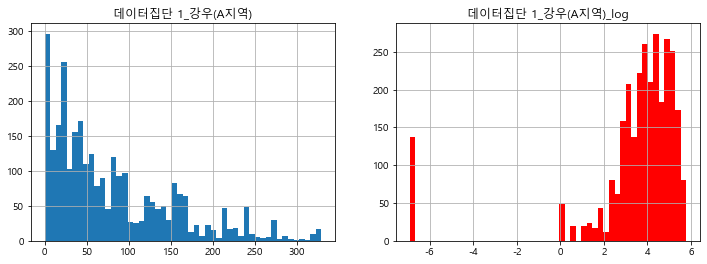

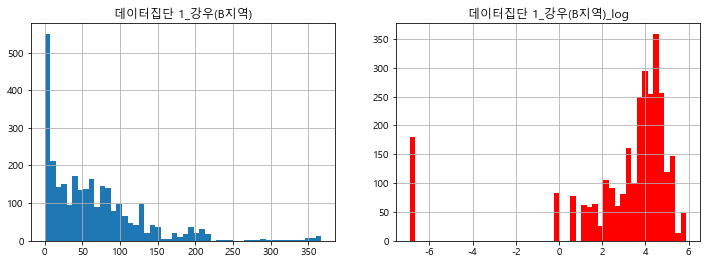

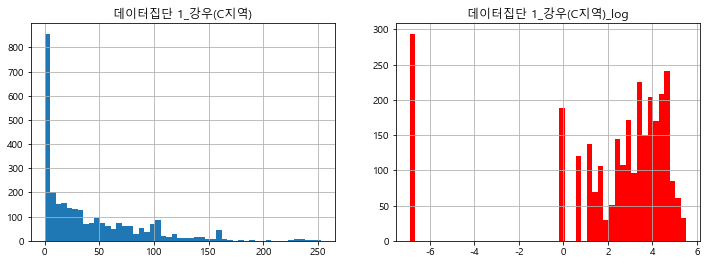

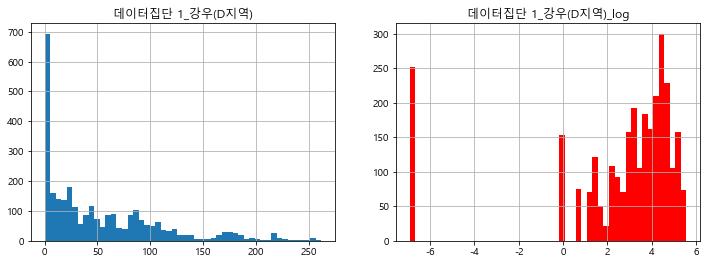

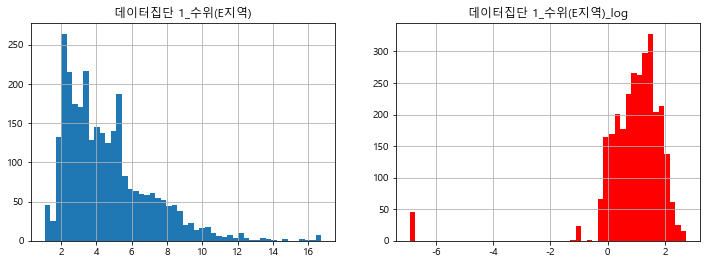

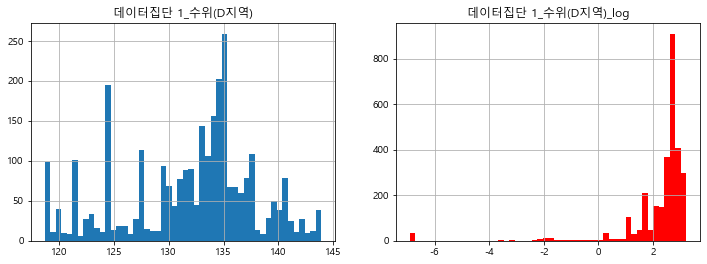

In [77]:
for col in data_raw.filter(regex='데이터집단 1').columns:
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1, 2, 1)
    data_raw[col].hist(bins=50, ax=ax1)
    ax1.set_title(col)
    
    ax2 = fig.add_subplot(1, 2, 2)
    np.log(data_raw[col] - data_raw[col].min() + 0.001).hist(bins=50, ax=ax2, color='r')
    ax2.set_title(col + '_log')
    plt.show()

In [73]:
name = 'log'
data_log = data_raw.copy()

log_col = data_log.columns.difference(list(data_log.filter(regex="수위\(D지역\)").columns) + [y_col] + PK_col)
for col in log_col:
    data_log[col + '_zero'] = (data_log[col] == 0).astype(int)
    data_log[col] = data_log[col].apply(lambda x : np.log(x - data_log[col].min() + 0.01))

In [78]:
predict_temp = dnn_predict(name, data_log, model_structure, robust_scaler, view=False, early_stop_num=10)

predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')

홍수사상번호 1 시작
Best Epoch: 820 Best Valid Loss: 2814751.75

홍수사상번호 2 시작
Best Epoch: 691 Best Valid Loss: 977796.12

홍수사상번호 3 시작
Best Epoch: 316 Best Valid Loss: 66954.70

홍수사상번호 4 시작
Best Epoch: 1777 Best Valid Loss: 91152.88

홍수사상번호 5 시작
Best Epoch: 1295 Best Valid Loss: 1542862.75

홍수사상번호 6 시작
Best Epoch: 1517 Best Valid Loss: 37332.90

홍수사상번호 7 시작
Best Epoch: 584 Best Valid Loss: 183572.44

홍수사상번호 8 시작
Best Epoch: 863 Best Valid Loss: 361724.56

홍수사상번호 9 시작
Best Epoch: 715 Best Valid Loss: 90124.75

홍수사상번호 10 시작
Best Epoch: 345 Best Valid Loss: 49765.09

홍수사상번호 11 시작
Best Epoch: 730 Best Valid Loss: 35181.22

홍수사상번호 12 시작
Best Epoch: 1884 Best Valid Loss: 112509.65

홍수사상번호 13 시작
Best Epoch: 476 Best Valid Loss: 103352.24

홍수사상번호 14 시작
Best Epoch: 1113 Best Valid Loss: 240476.55

홍수사상번호 15 시작
Best Epoch: 762 Best Valid Loss: 50297.05

홍수사상번호 16 시작
Best Epoch: 359 Best Valid Loss: 28733.29

홍수사상번호 17 시작
Best Epoch: 836 Best Valid Loss: 96395.22

홍수사상번호 18 시작
Best Epoch: 381 Best Valid Lo

In [79]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [80]:
score_df

RMSE  RMSLE  R2_score  MAPE
base               507.27   0.51      0.95 26.28
base_2123          501.96   0.47      0.95 22.39
t-1 t+1            463.56   0.34      0.95 22.24
waterlevel t-1 t+1 536.74   0.43      0.94 25.45
3 cluster          491.36   0.42      0.95 24.72
4 cluster          486.95   0.49      0.95 27.22
5 cluster          496.49   0.49      0.95 24.32
6 cluster          496.28   0.51      0.95 24.69
6cluster + t       478.63   0.42      0.95 25.84
log                621.58   0.72      0.92 39.19

## log 변환

In [81]:
name = 'origin + log'
data_originlog = data_raw.copy()

log_col = data_originlog.columns.difference(list(data_originlog.filter(regex="수위\(D지역\)").columns) + [y_col] + PK_col)
for col in log_col:
    data_originlog[col + '_zero'] = (data_originlog[col] == 0).astype(int)
    data_originlog[col + '_log'] = data_originlog[col].apply(lambda x : np.log(x - data_originlog[col].min() + 0.01))

In [82]:
predict_temp = dnn_predict(name, data_originlog, model_structure, robust_scaler, view=False, early_stop_num=10)

predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')

홍수사상번호 1 시작
Best Epoch: 976 Best Valid Loss: 1523319.25

홍수사상번호 2 시작
Best Epoch: 497 Best Valid Loss: 802676.44

홍수사상번호 3 시작
Best Epoch: 270 Best Valid Loss: 46349.39

홍수사상번호 4 시작
Best Epoch: 328 Best Valid Loss: 187296.44

홍수사상번호 5 시작
Best Epoch: 460 Best Valid Loss: 1209954.38

홍수사상번호 6 시작
Best Epoch: 324 Best Valid Loss: 54429.52

홍수사상번호 7 시작
Best Epoch: 311 Best Valid Loss: 338401.06

홍수사상번호 8 시작
Best Epoch: 555 Best Valid Loss: 505617.88

홍수사상번호 9 시작
Best Epoch: 448 Best Valid Loss: 51985.85

홍수사상번호 10 시작
Best Epoch: 283 Best Valid Loss: 42755.31

홍수사상번호 11 시작
Best Epoch: 891 Best Valid Loss: 52053.95

홍수사상번호 12 시작
Best Epoch: 581 Best Valid Loss: 54282.82

홍수사상번호 13 시작
Best Epoch: 845 Best Valid Loss: 83481.13

홍수사상번호 14 시작
Best Epoch: 1003 Best Valid Loss: 196301.80

홍수사상번호 15 시작
Best Epoch: 434 Best Valid Loss: 77420.66

홍수사상번호 16 시작
Best Epoch: 311 Best Valid Loss: 20827.63

홍수사상번호 17 시작
Best Epoch: 562 Best Valid Loss: 191974.83

홍수사상번호 18 시작
Best Epoch: 301 Best Valid Loss: 

In [83]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [84]:
score_df

RMSE  RMSLE  R2_score  MAPE
base               507.27   0.51      0.95 26.28
base_2123          501.96   0.47      0.95 22.39
t-1 t+1            463.56   0.34      0.95 22.24
waterlevel t-1 t+1 536.74   0.43      0.94 25.45
3 cluster          491.36   0.42      0.95 24.72
4 cluster          486.95   0.49      0.95 27.22
5 cluster          496.49   0.49      0.95 24.32
6 cluster          496.28   0.51      0.95 24.69
6cluster + t       478.63   0.42      0.95 25.84
log                621.58   0.72      0.92 39.19
origin + log       539.39   0.49      0.94 32.92

## x^2 변환

In [85]:
name = 'x2'
data_x2 = data_raw.copy()

x2_col = data_x2.filter(regex="수위\(D지역\)").columns
for col in x2_col:
    data_x2[col + '_x2'] = data_x2[col] ** 2

In [87]:
predict_temp = dnn_predict(name, data_x2, model_structure, robust_scaler, view=False, early_stop_num=10)

predict_df = pd.merge(predict_df, predict_temp, on=PK_col+['true'], how='outer')

홍수사상번호 1 시작
Best Epoch: 981 Best Valid Loss: 1349341.75

홍수사상번호 2 시작
Best Epoch: 1116 Best Valid Loss: 796334.88

홍수사상번호 3 시작
Best Epoch: 431 Best Valid Loss: 40008.97

홍수사상번호 4 시작
Best Epoch: 463 Best Valid Loss: 150328.41

홍수사상번호 5 시작
Best Epoch: 687 Best Valid Loss: 1155548.50

홍수사상번호 6 시작
Best Epoch: 1639 Best Valid Loss: 46410.29

홍수사상번호 7 시작
Best Epoch: 540 Best Valid Loss: 337452.44

홍수사상번호 8 시작
Best Epoch: 672 Best Valid Loss: 486099.19

홍수사상번호 9 시작
Best Epoch: 734 Best Valid Loss: 73852.26

홍수사상번호 10 시작
Best Epoch: 509 Best Valid Loss: 51595.19

홍수사상번호 11 시작
Best Epoch: 500 Best Valid Loss: 55724.37

홍수사상번호 12 시작
Best Epoch: 604 Best Valid Loss: 55566.29

홍수사상번호 13 시작
Best Epoch: 618 Best Valid Loss: 69275.19

홍수사상번호 14 시작
Best Epoch: 927 Best Valid Loss: 201179.39

홍수사상번호 15 시작
Best Epoch: 846 Best Valid Loss: 52716.47

홍수사상번호 16 시작
Best Epoch: 458 Best Valid Loss: 31805.34

홍수사상번호 17 시작
Best Epoch: 915 Best Valid Loss: 196070.22

홍수사상번호 18 시작
Best Epoch: 548 Best Valid Loss:

In [88]:
score_df.loc[name, "RMSE"] = rmse(predict_df,name)
score_df.loc[name, "RMSLE"] = rmsle(predict_df,name)
score_df.loc[name, "R2_score"] = r2(predict_df,name)
score_df.loc[name, "MAPE"] = mape(predict_df,name)

In [89]:
score_df

RMSE  RMSLE  R2_score  MAPE
base               507.27   0.51      0.95 26.28
base_2123          501.96   0.47      0.95 22.39
t-1 t+1            463.56   0.34      0.95 22.24
waterlevel t-1 t+1 536.74   0.43      0.94 25.45
3 cluster          491.36   0.42      0.95 24.72
4 cluster          486.95   0.49      0.95 27.22
5 cluster          496.49   0.49      0.95 24.32
6 cluster          496.28   0.51      0.95 24.69
6cluster + t       478.63   0.42      0.95 25.84
log                621.58   0.72      0.92 39.19
origin + log       539.39   0.49      0.94 32.92
x2                 508.34   0.45      0.95 24.19

## model result plot

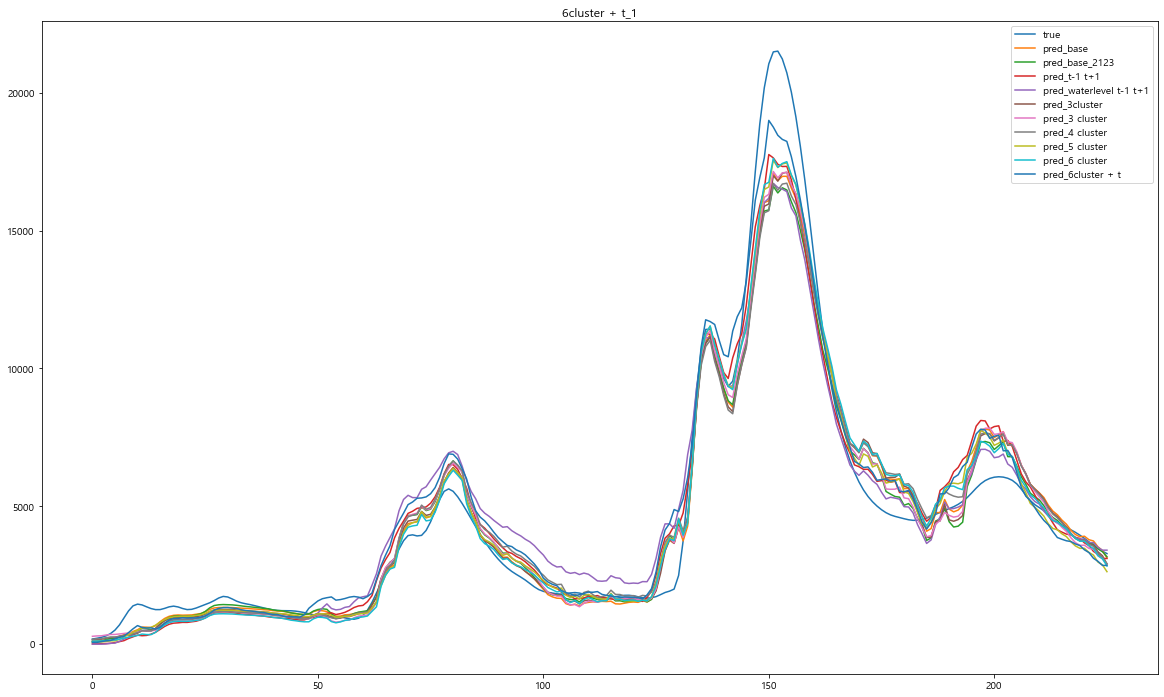

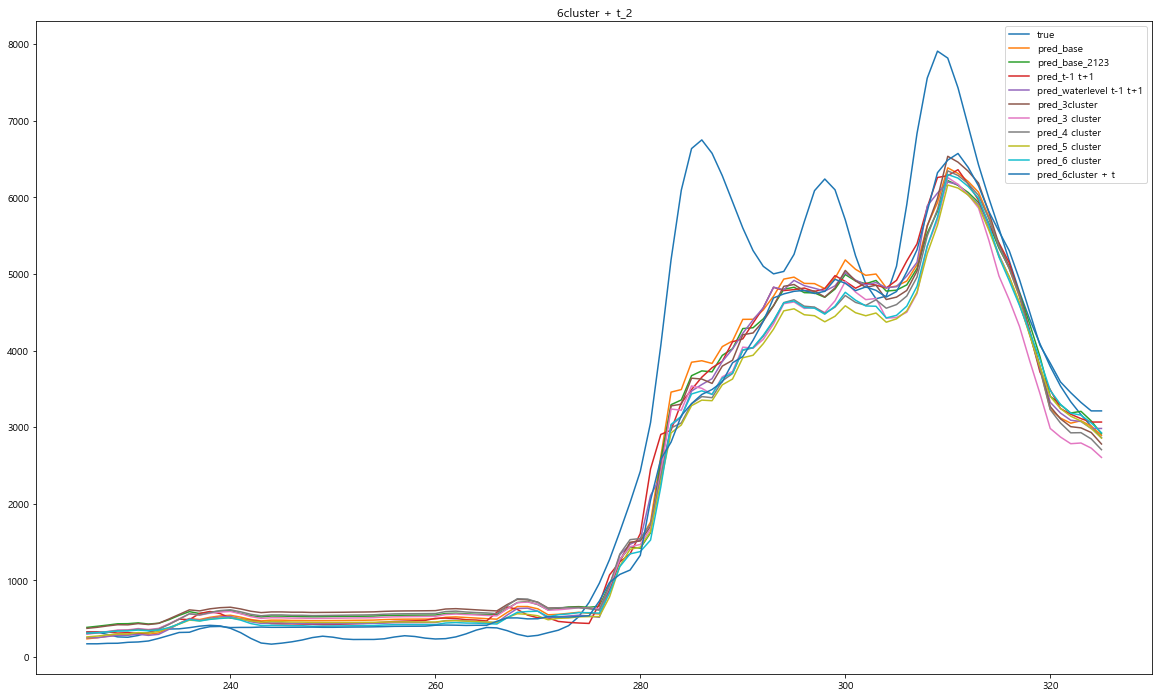

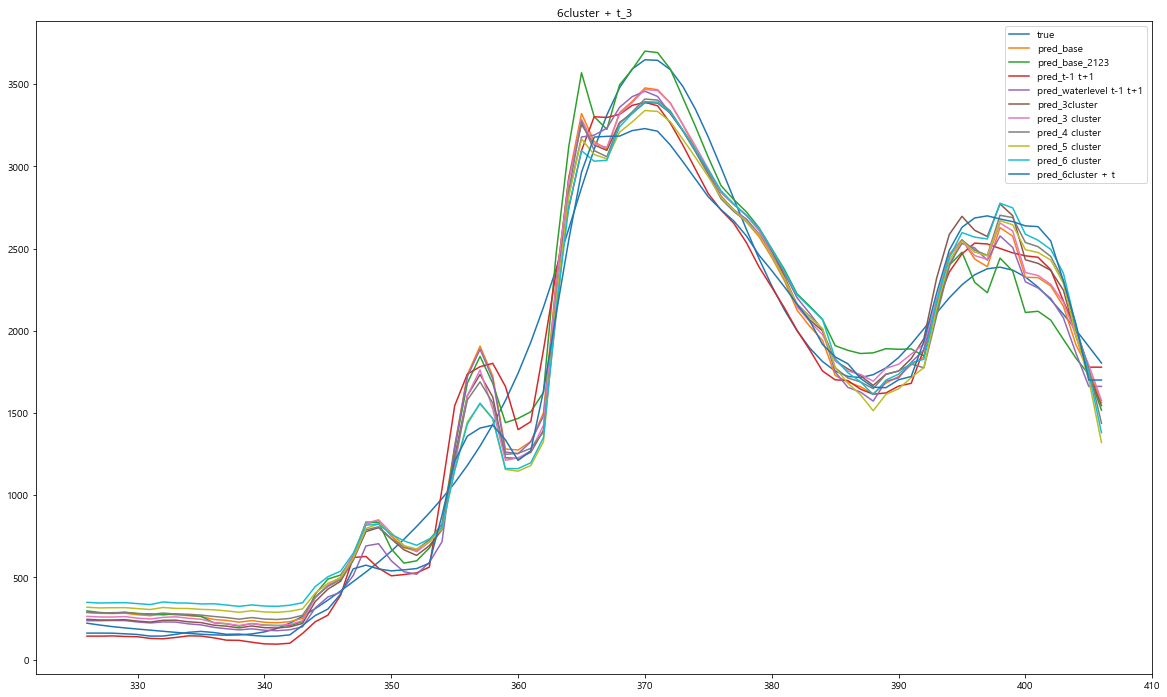

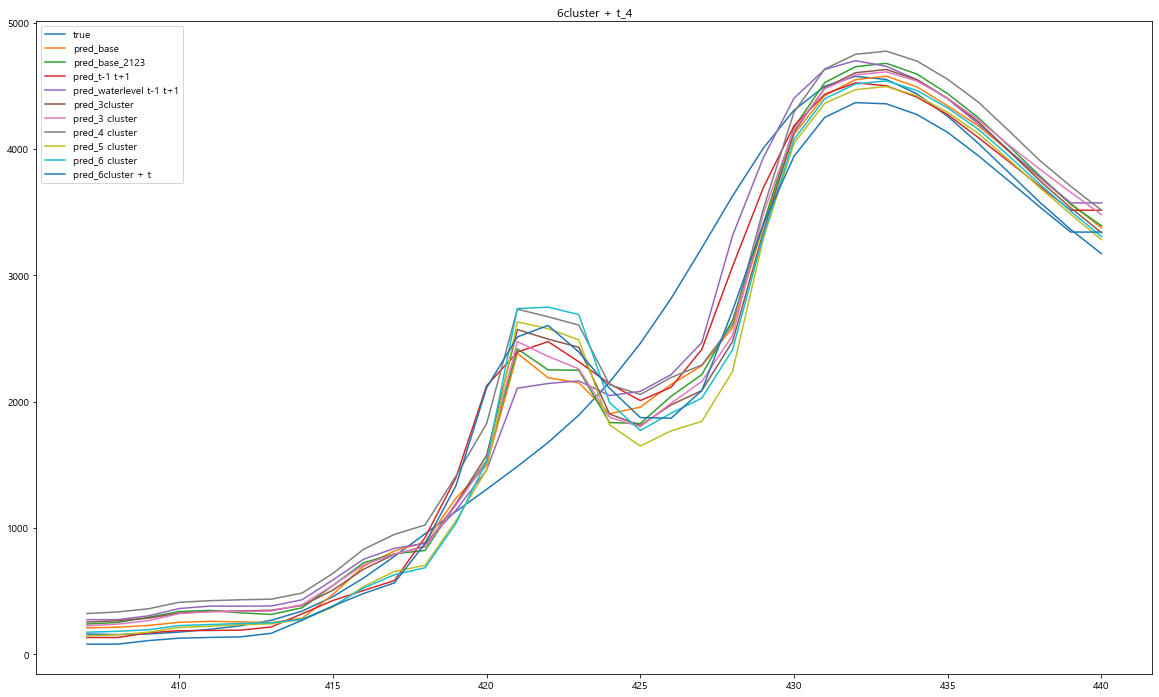

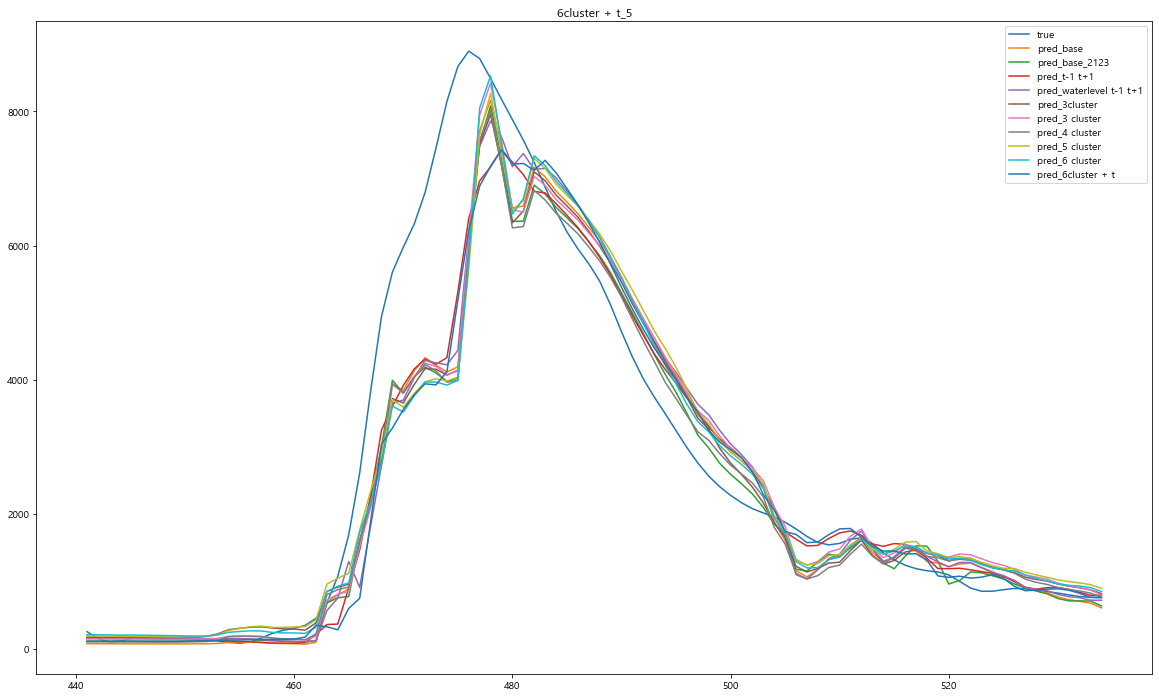

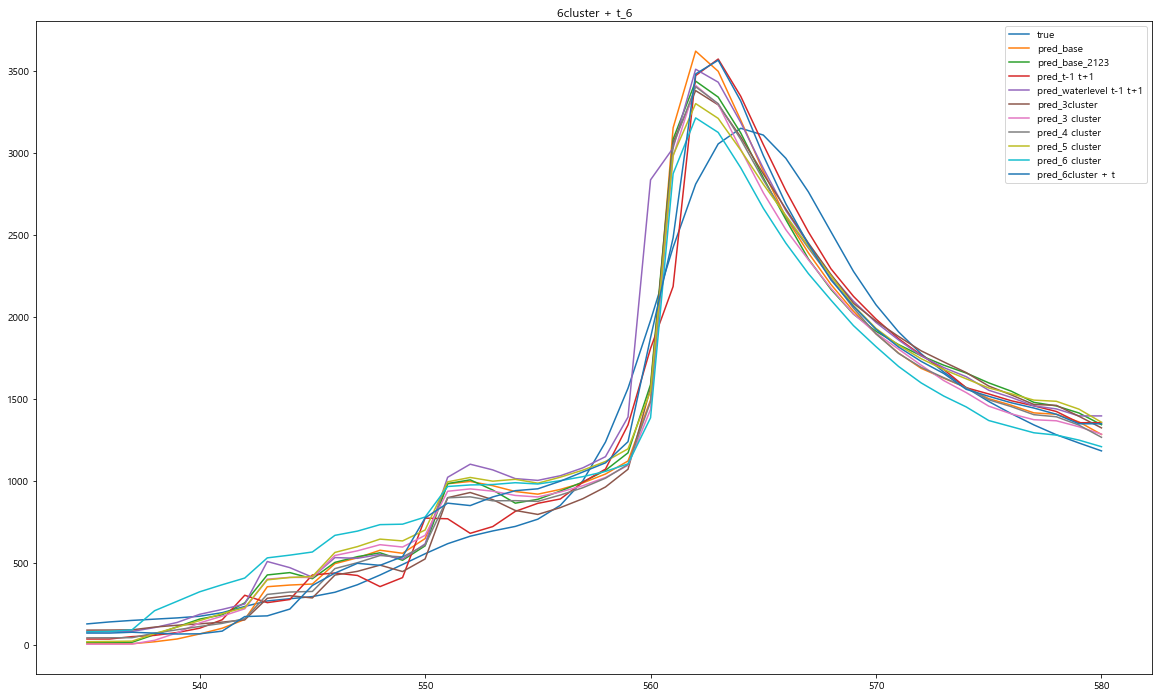

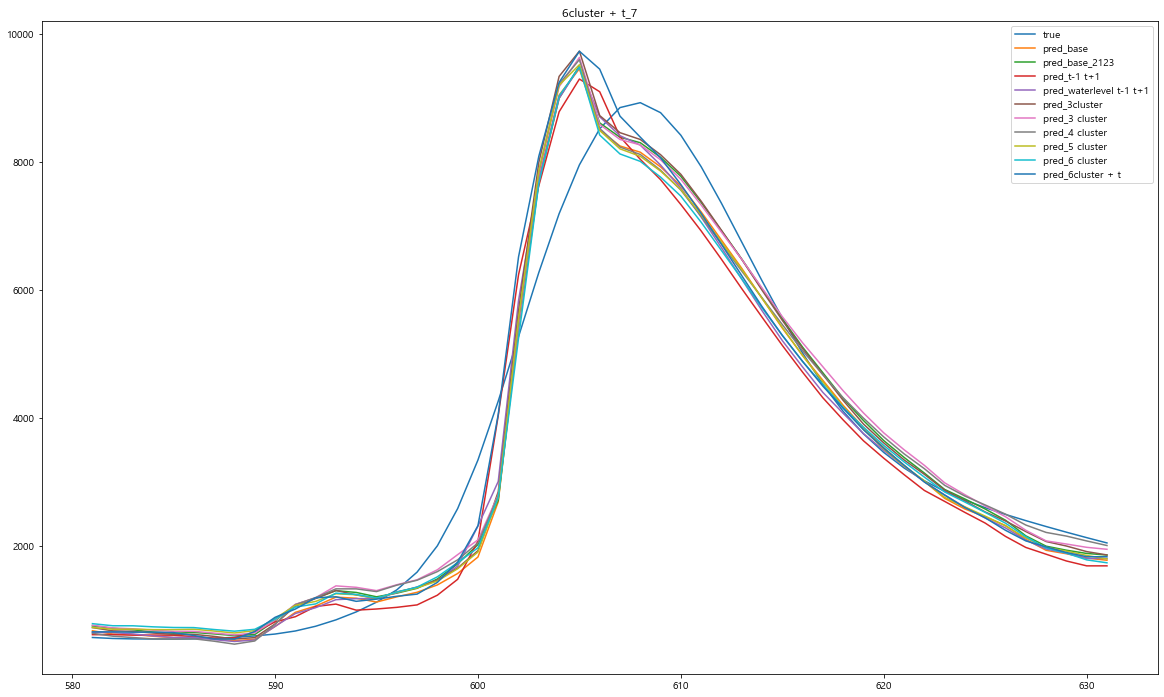

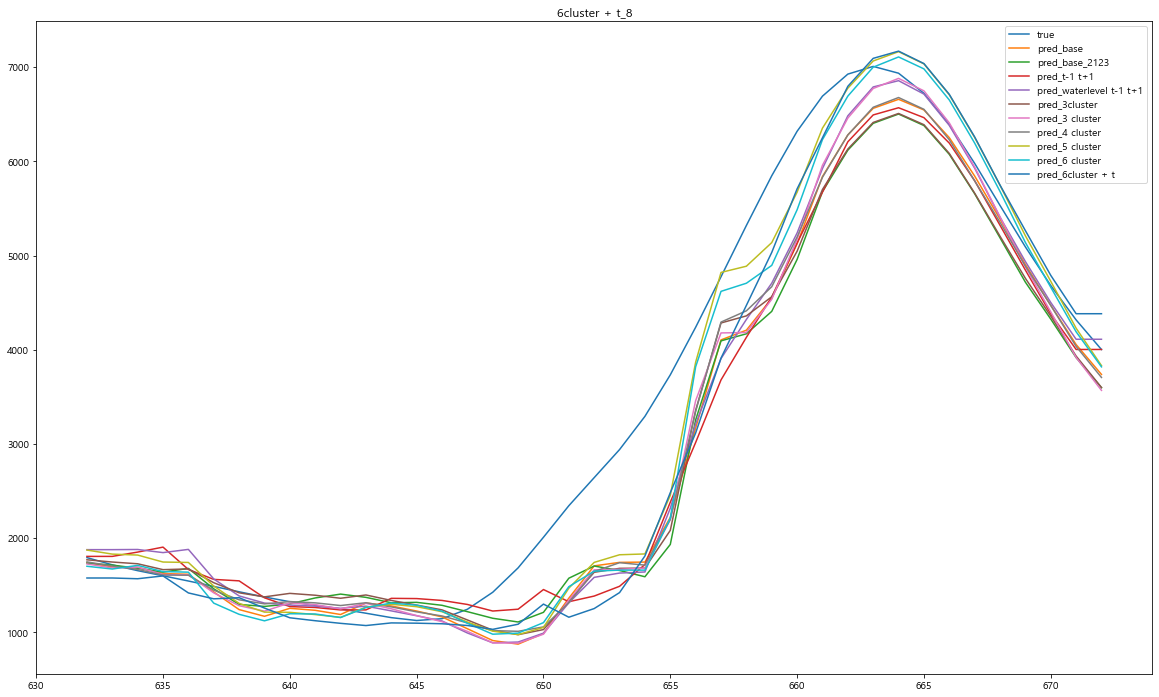

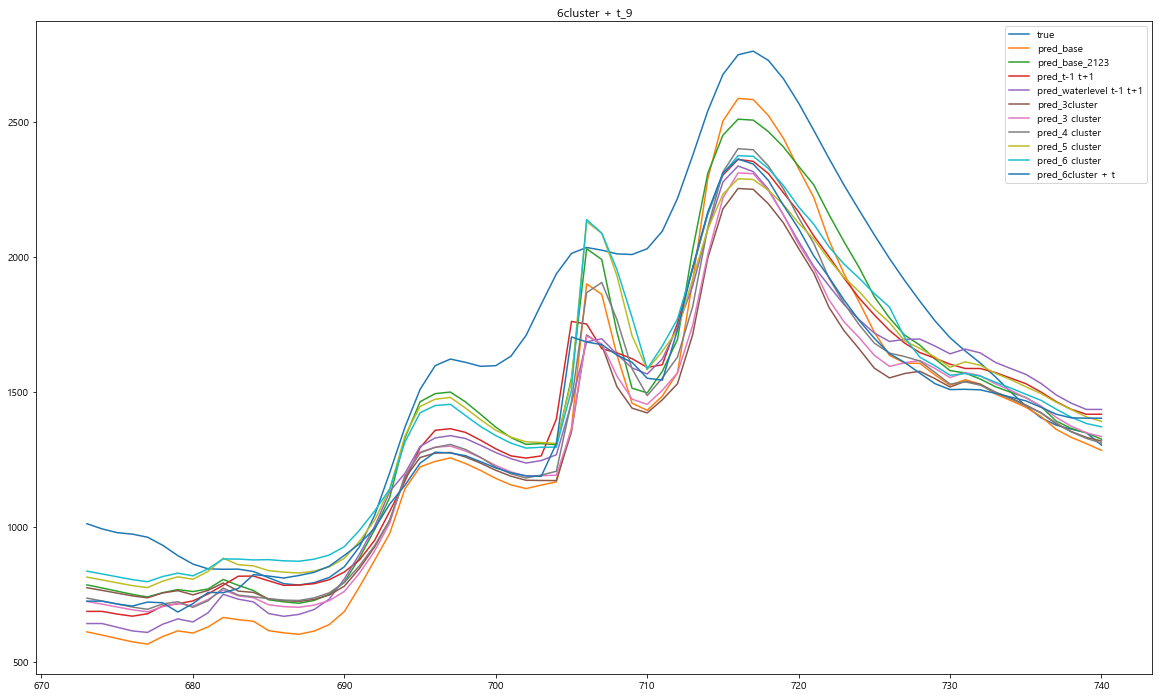

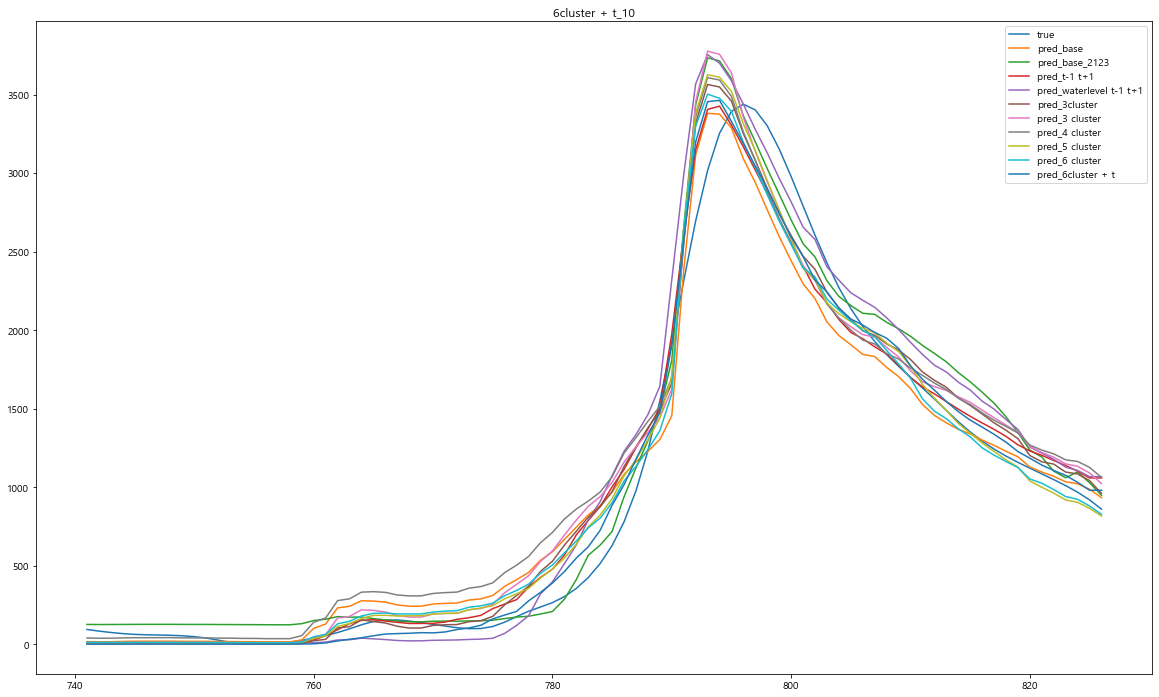

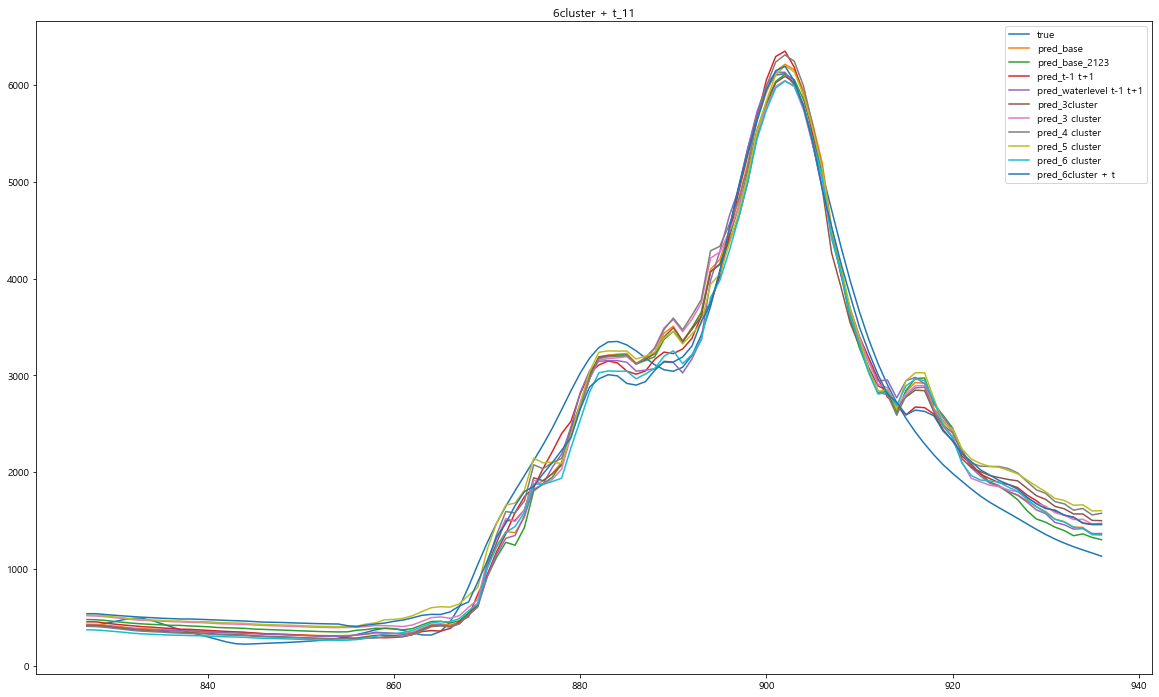

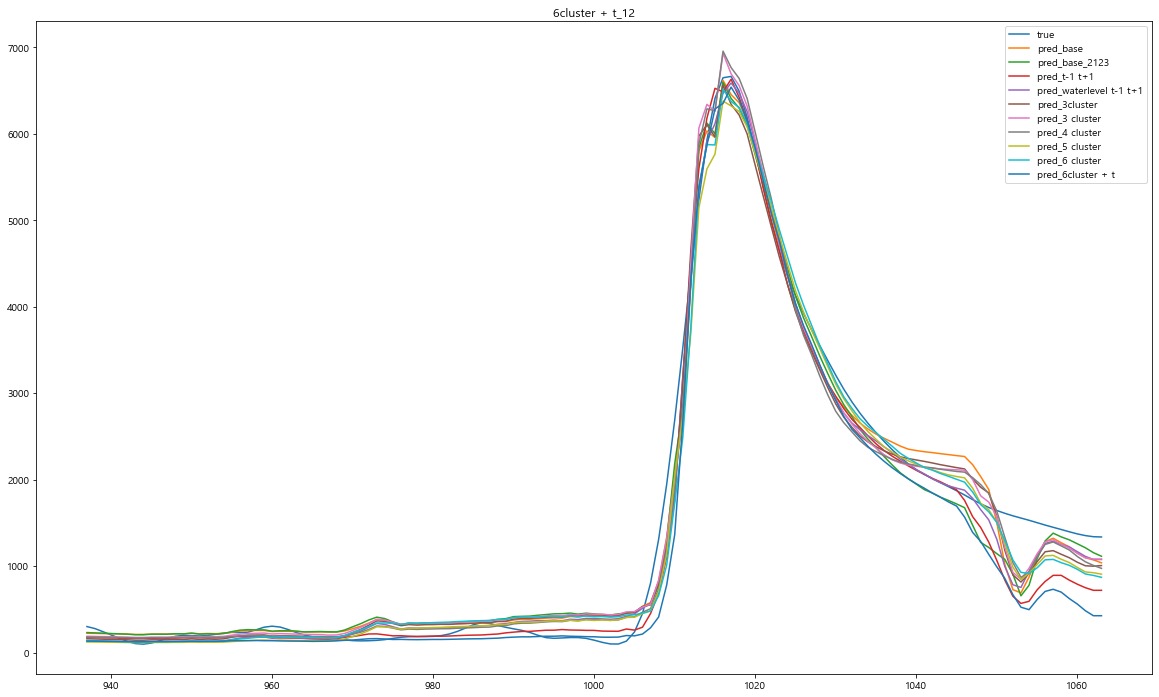

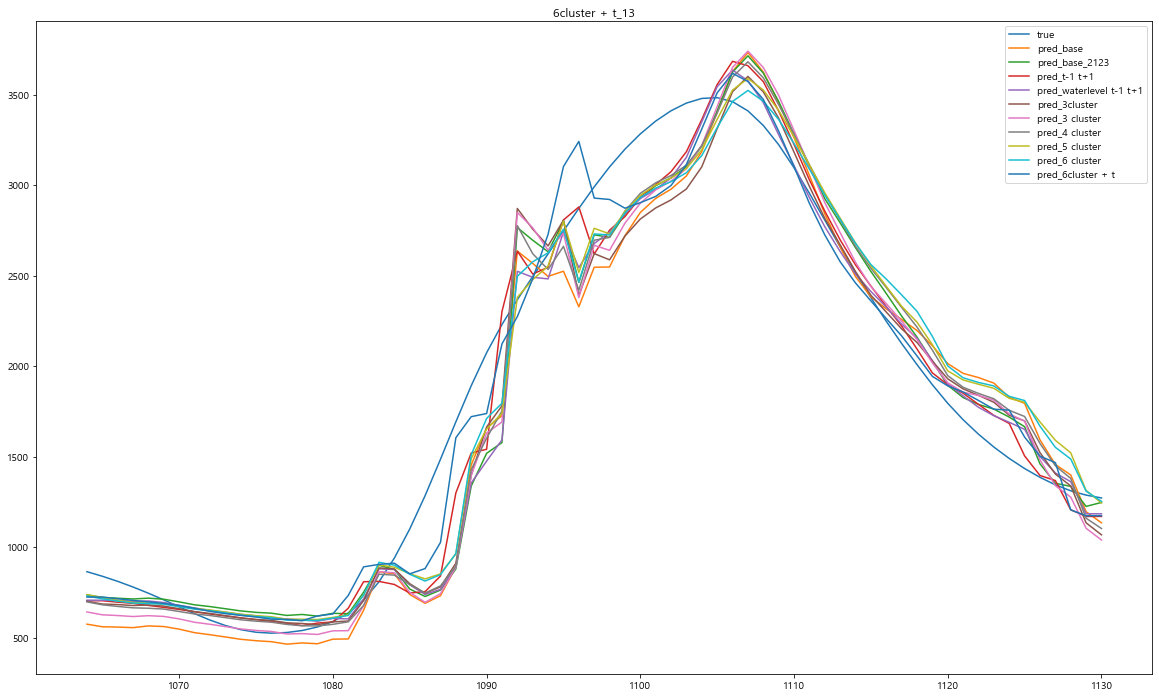

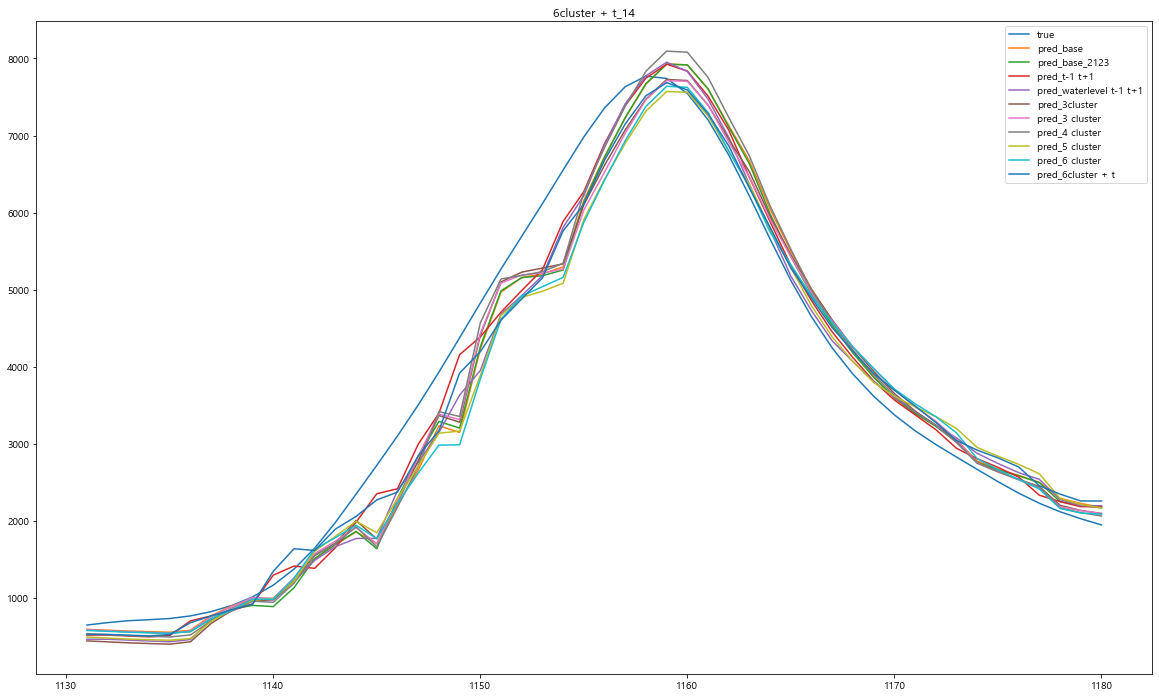

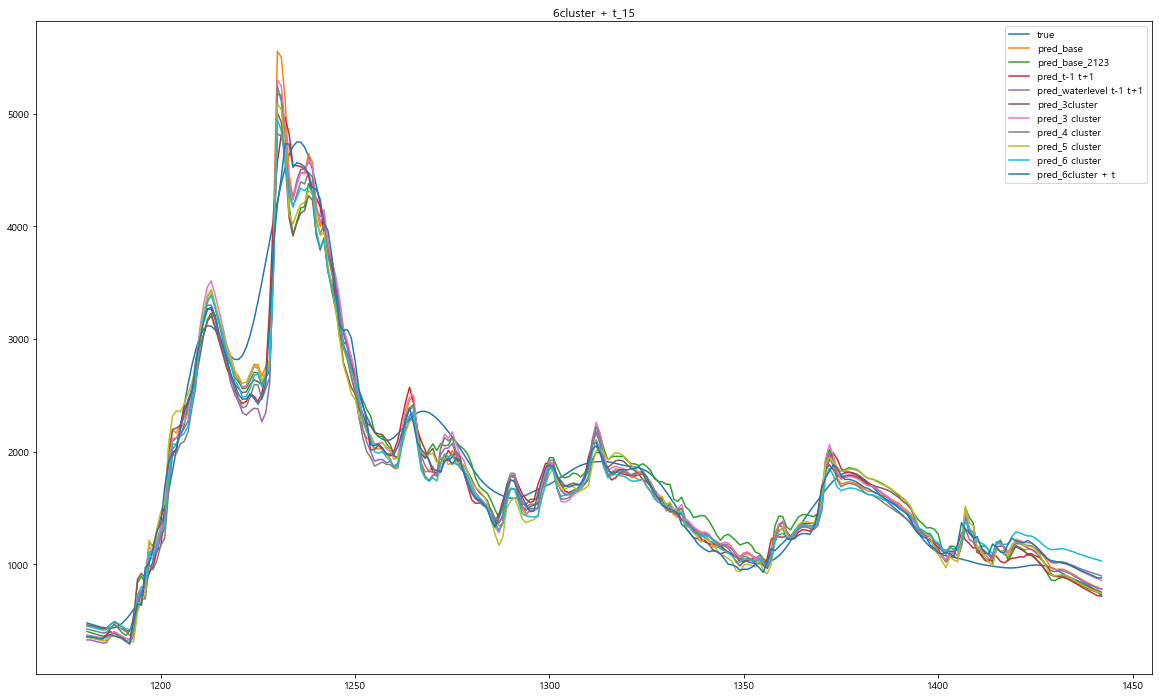

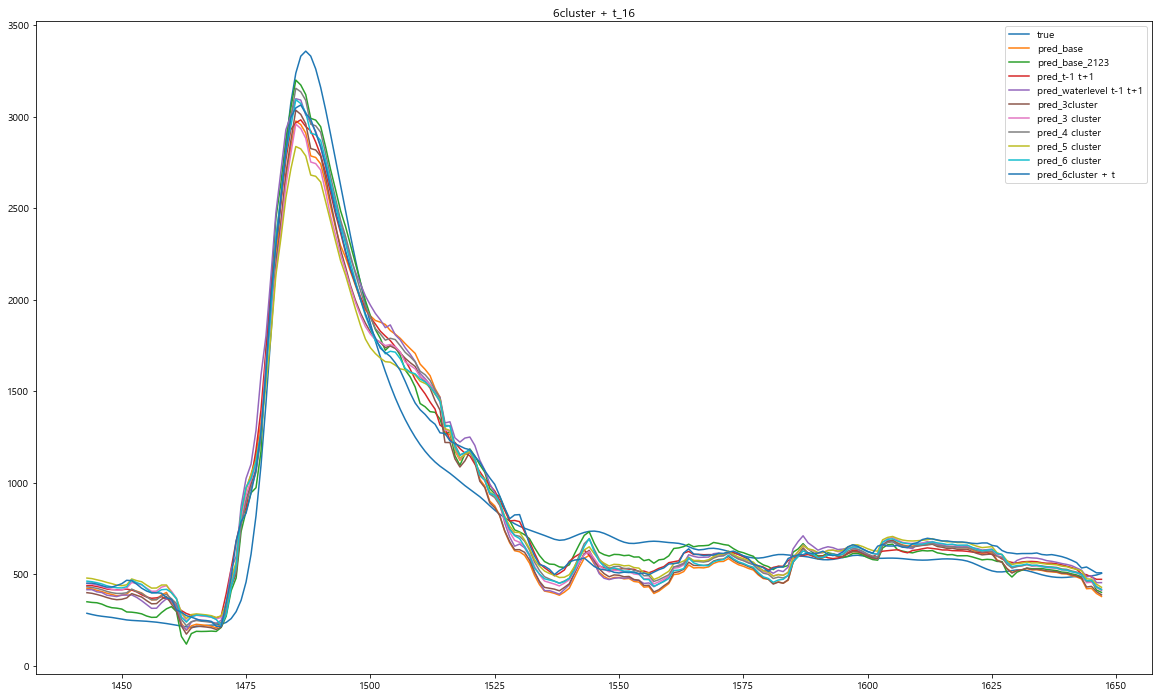

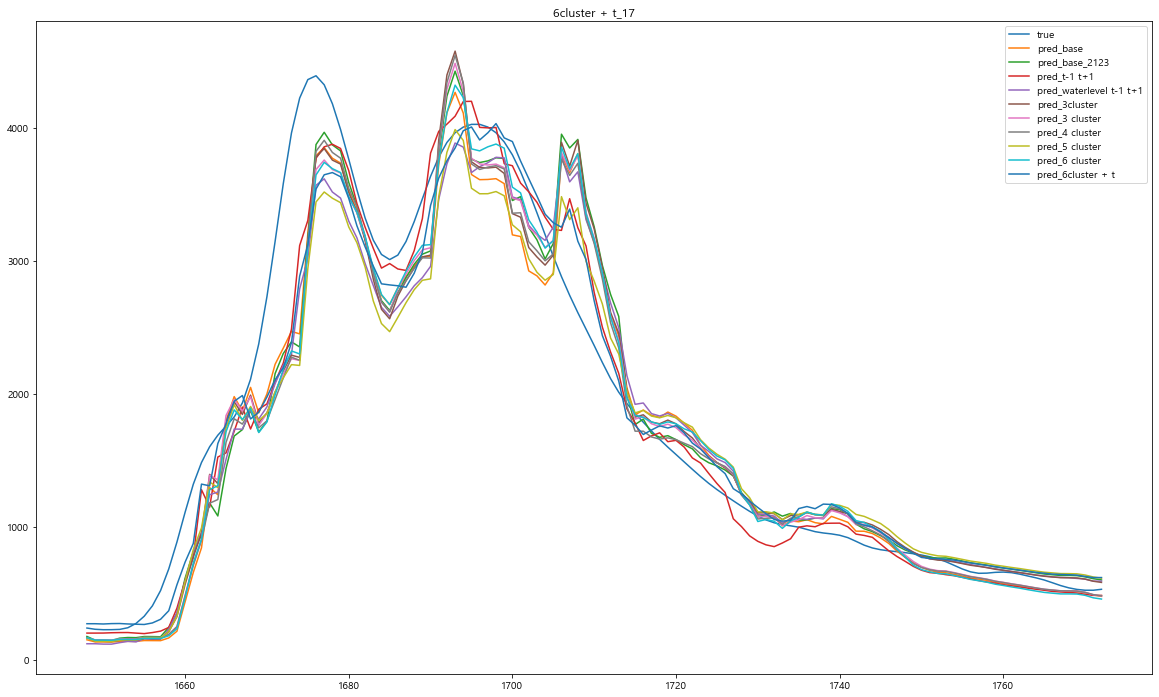

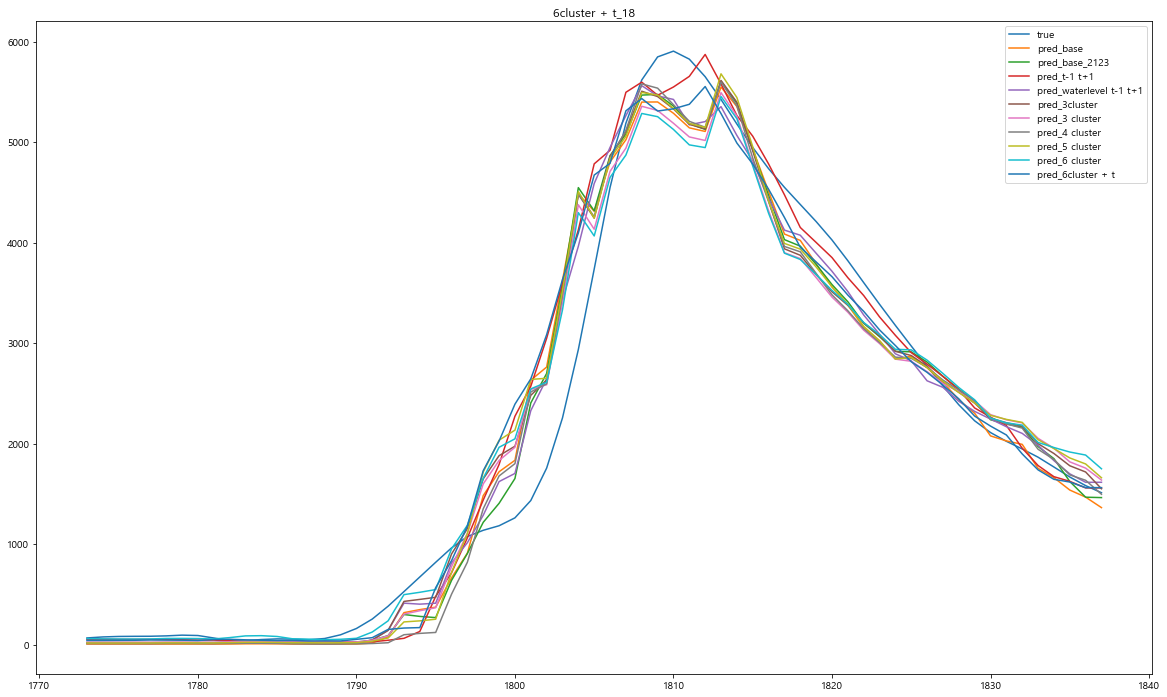

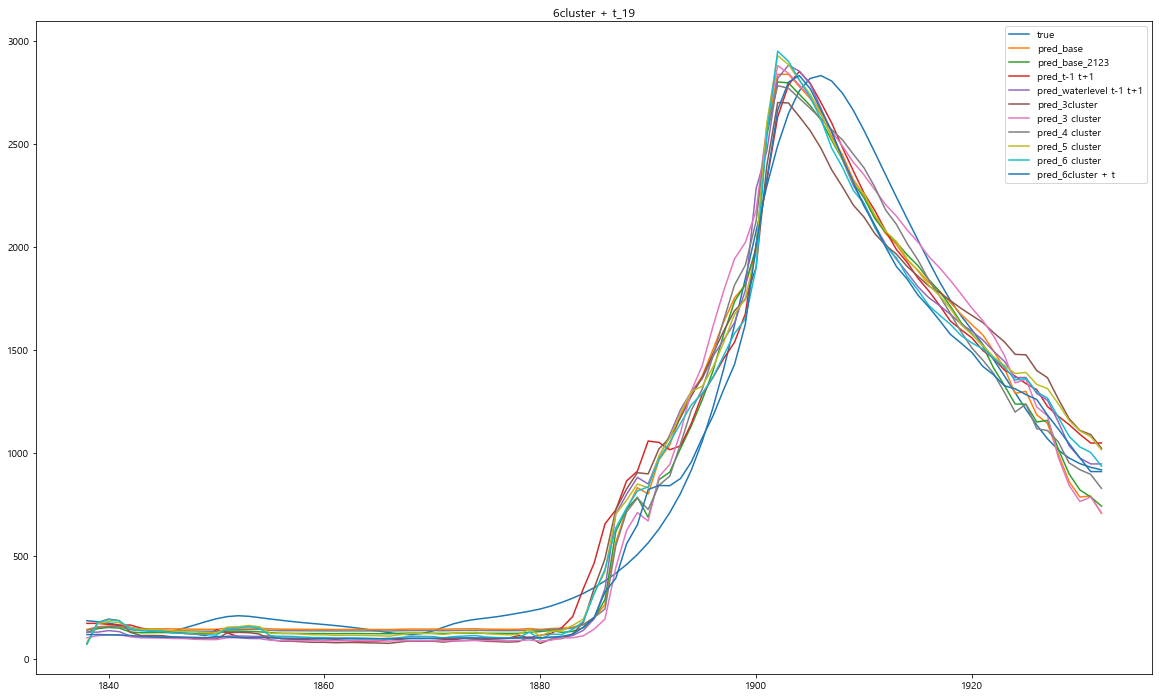

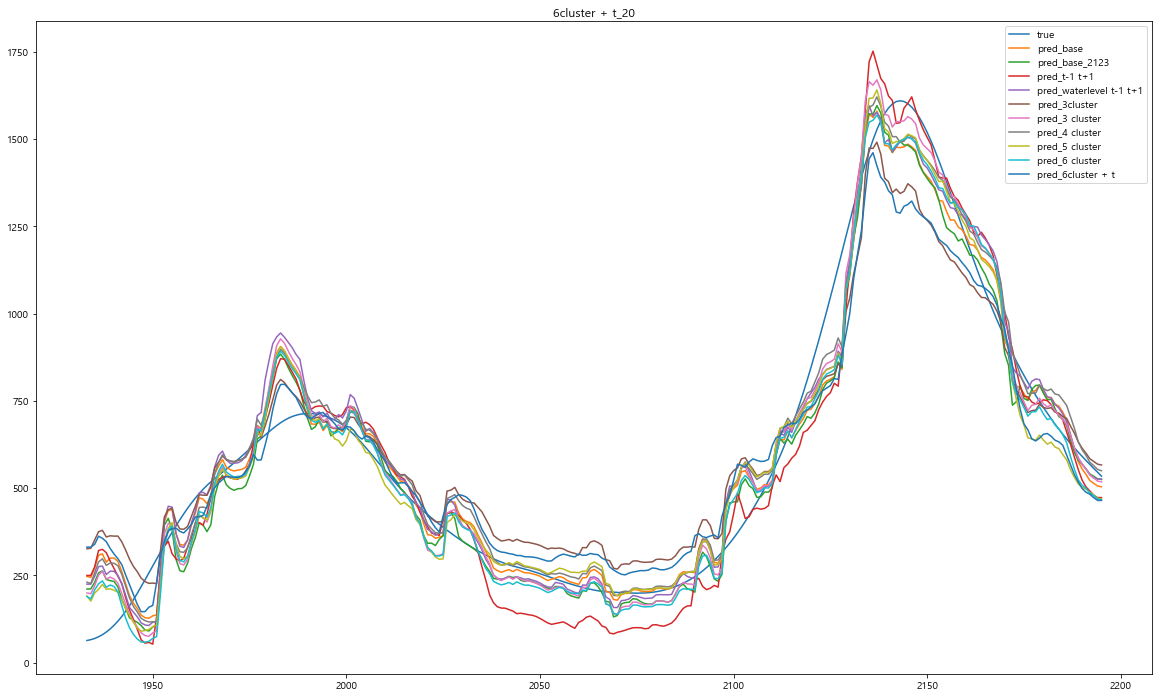

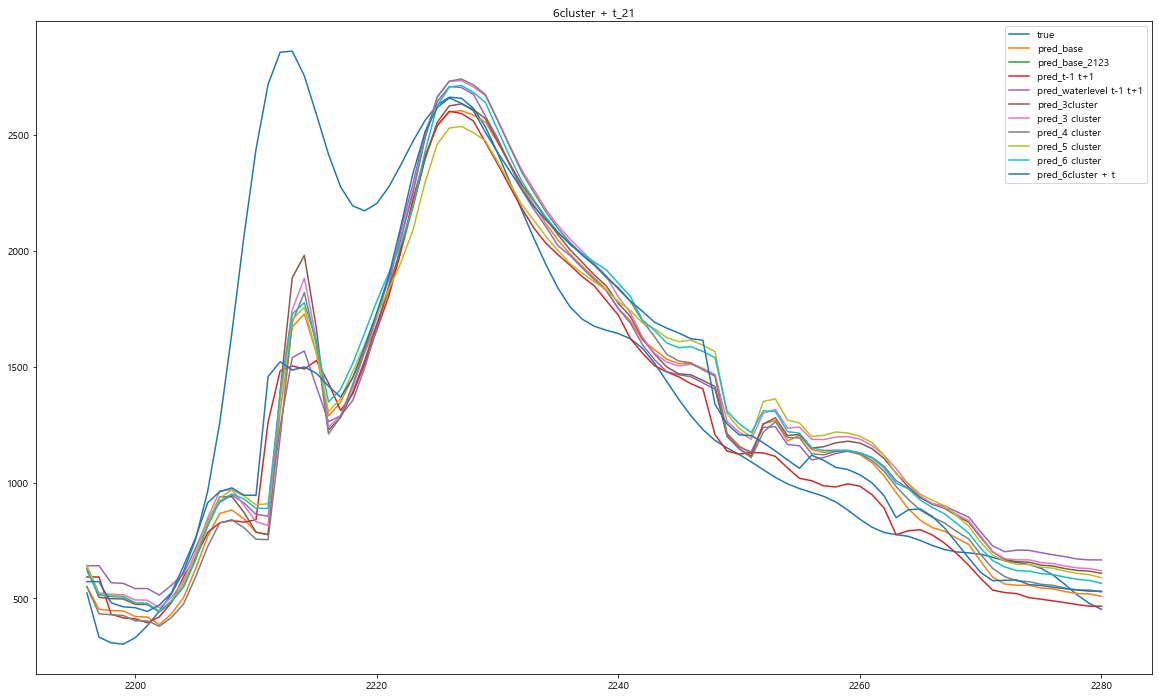

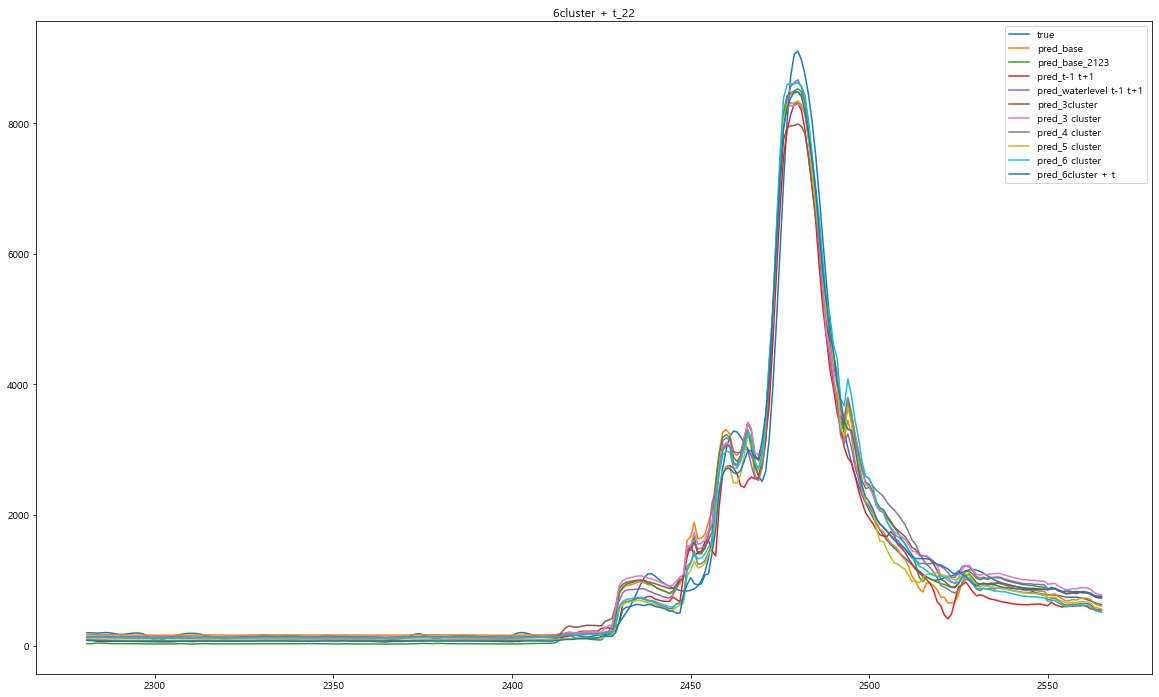

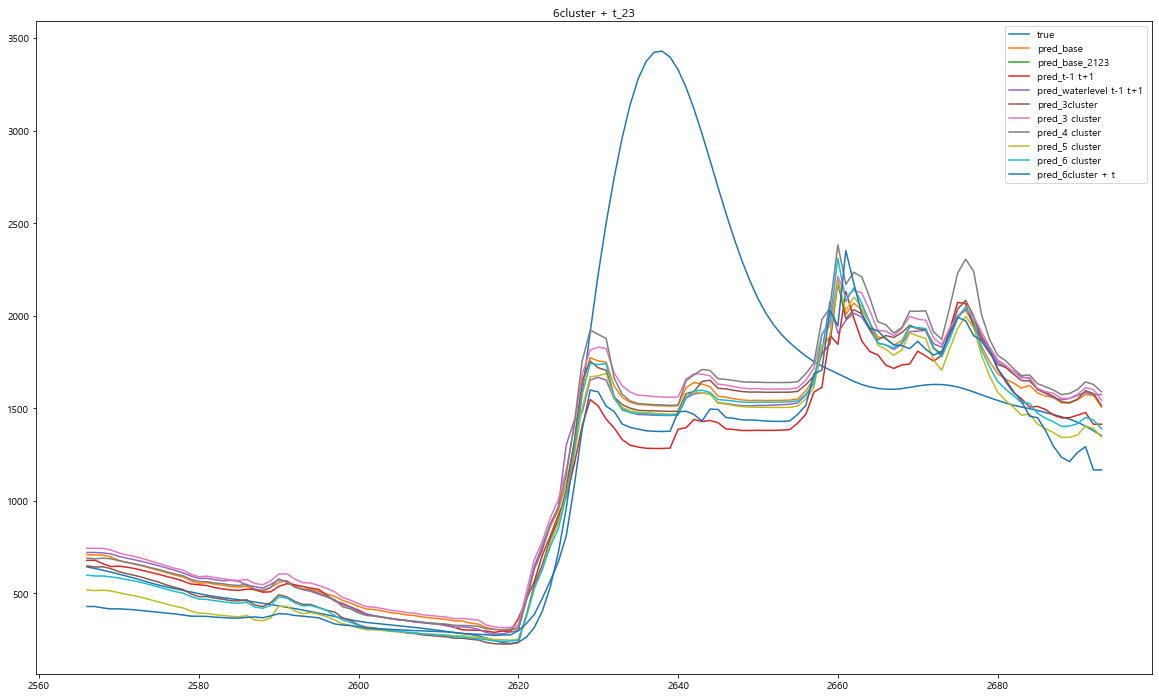

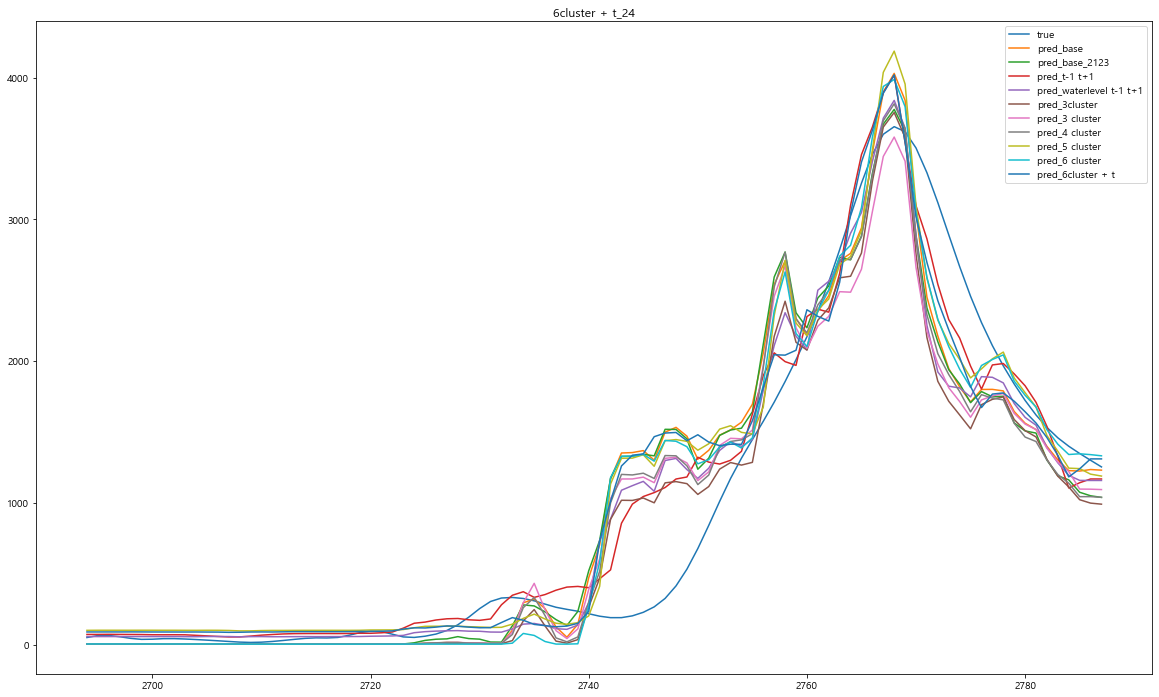

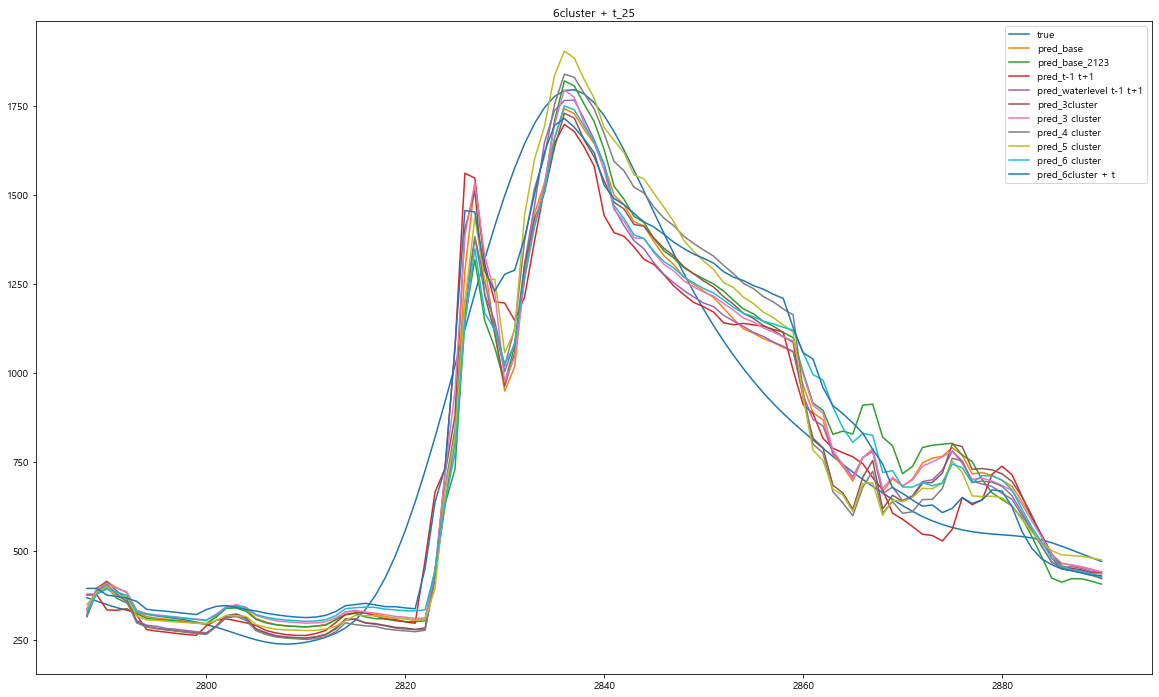

In [56]:
plot_hongsunum(predict_df)

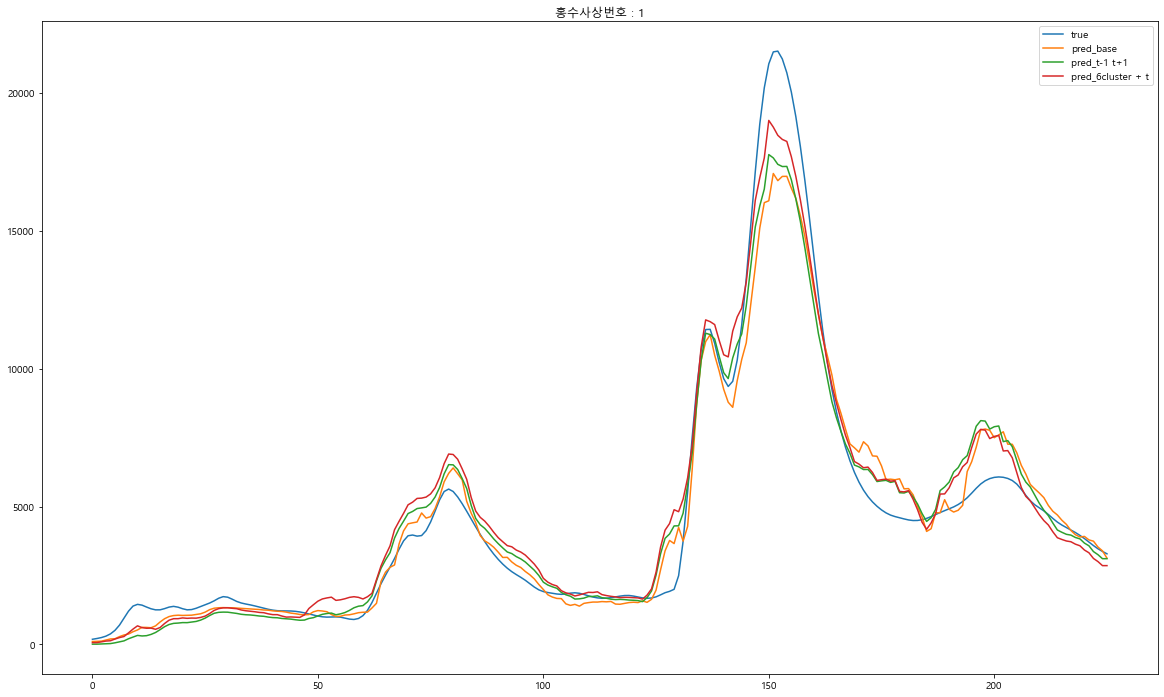

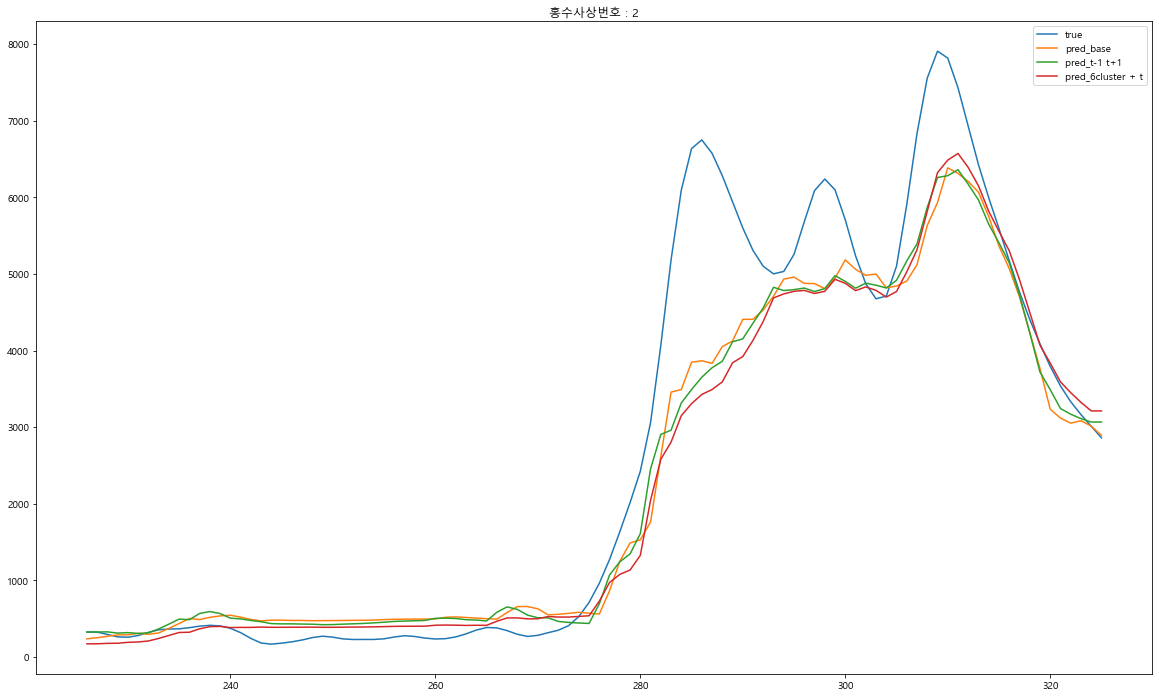

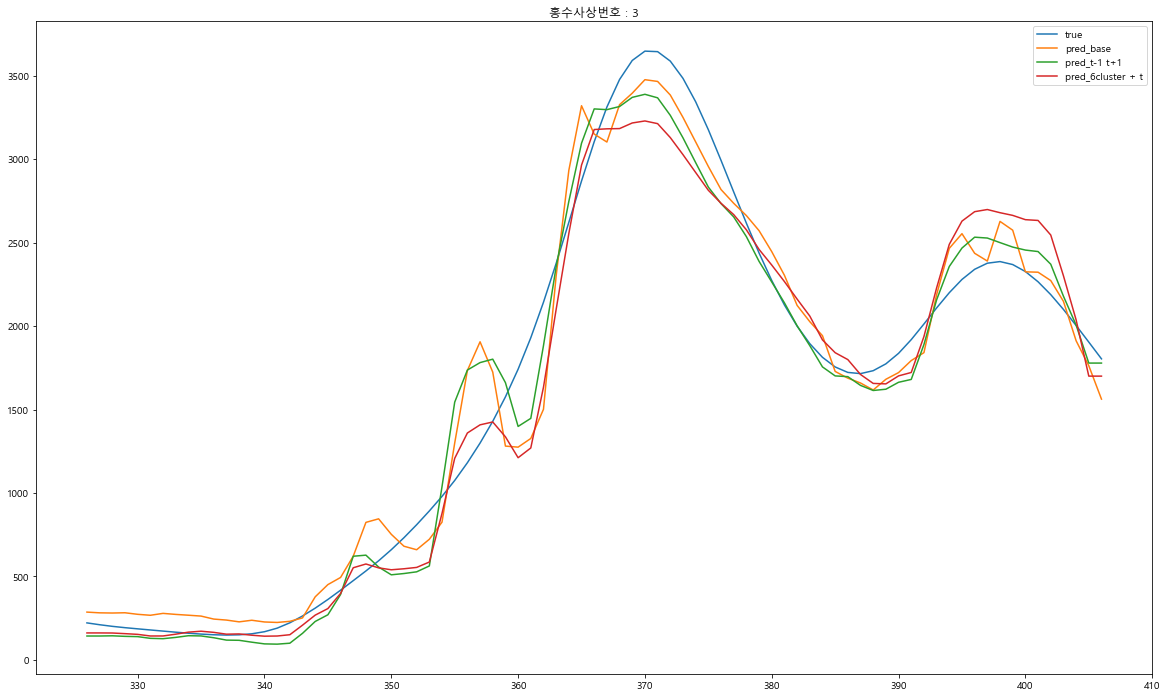

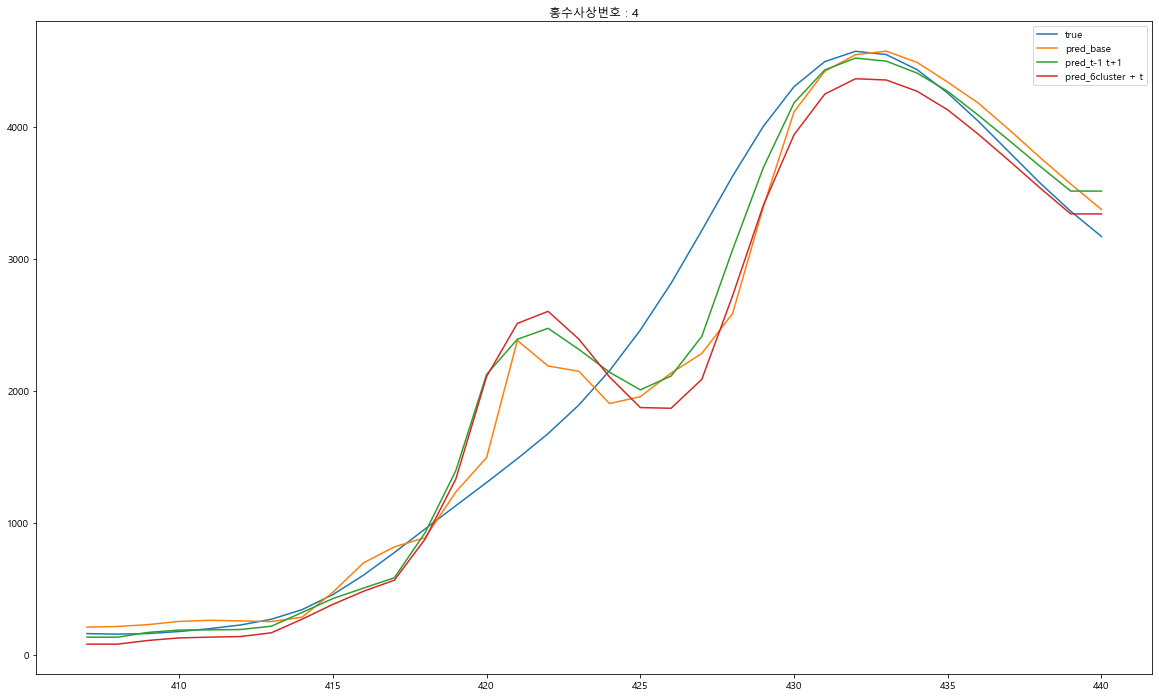

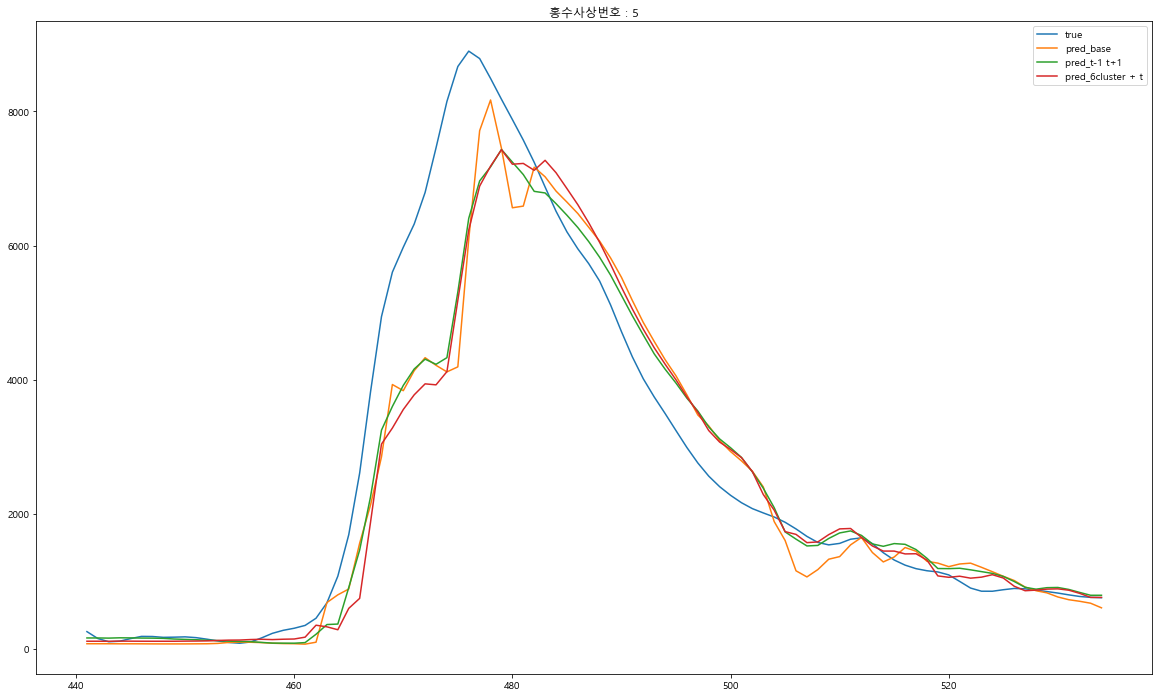

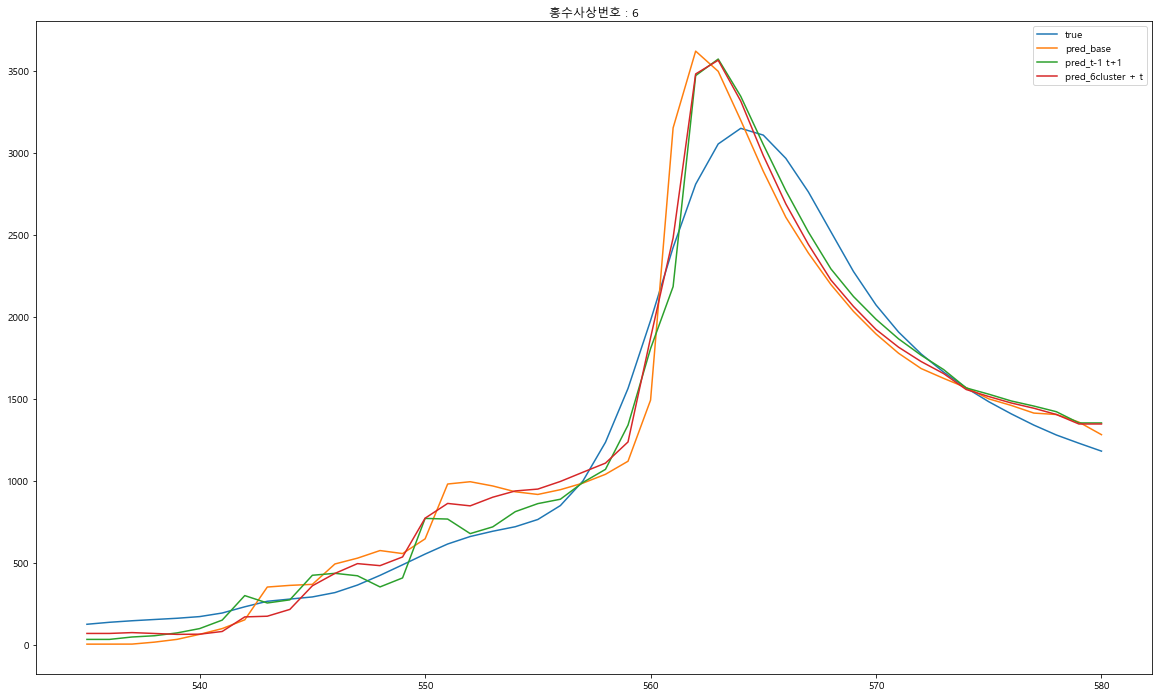

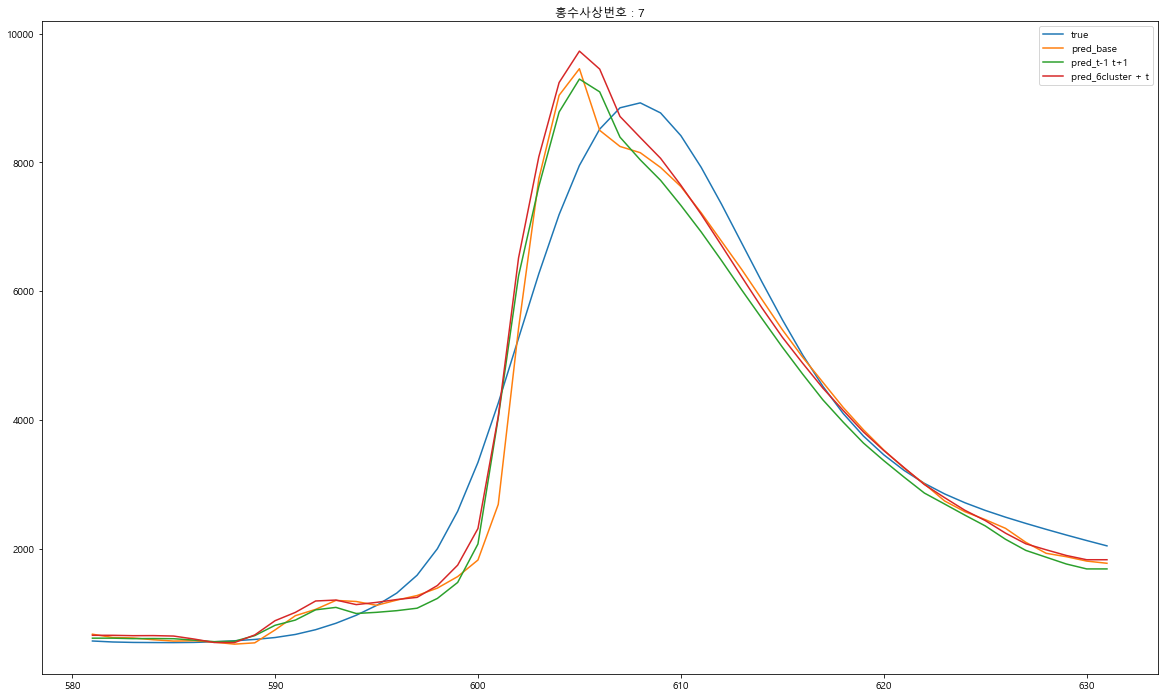

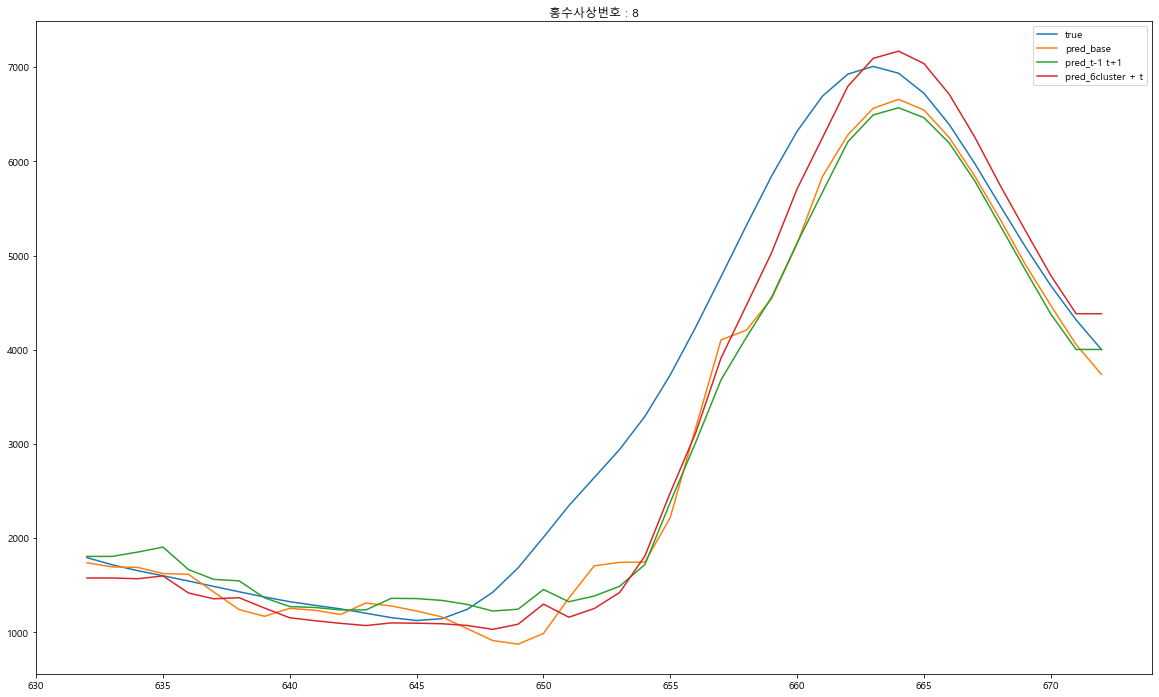

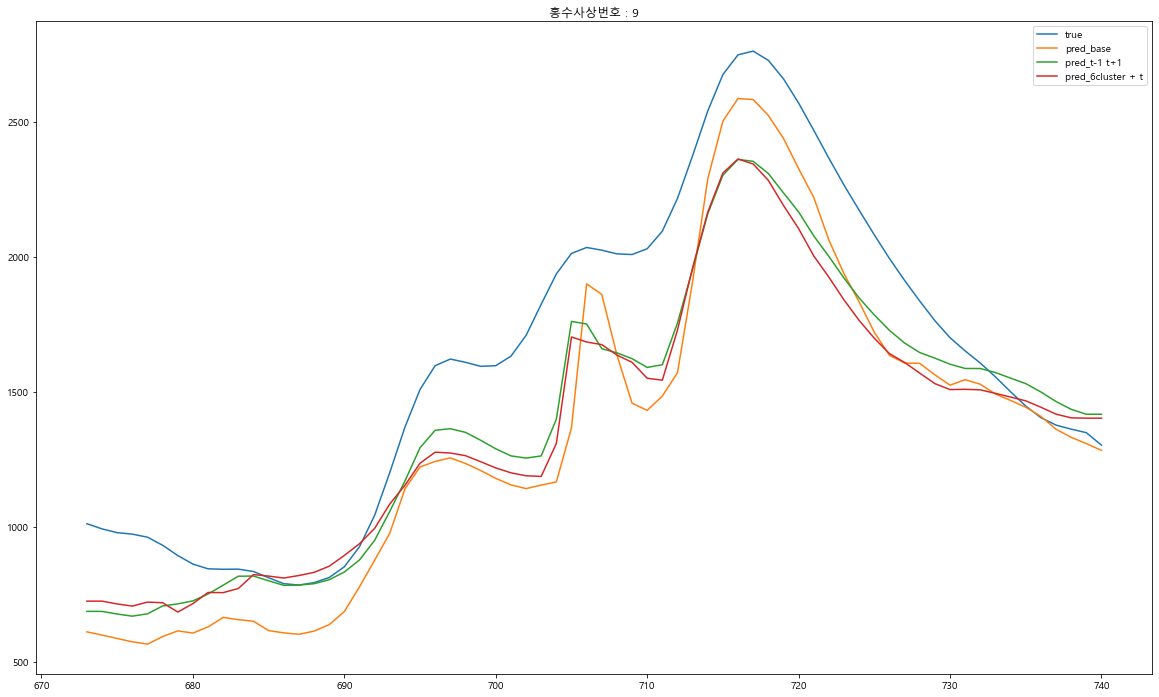

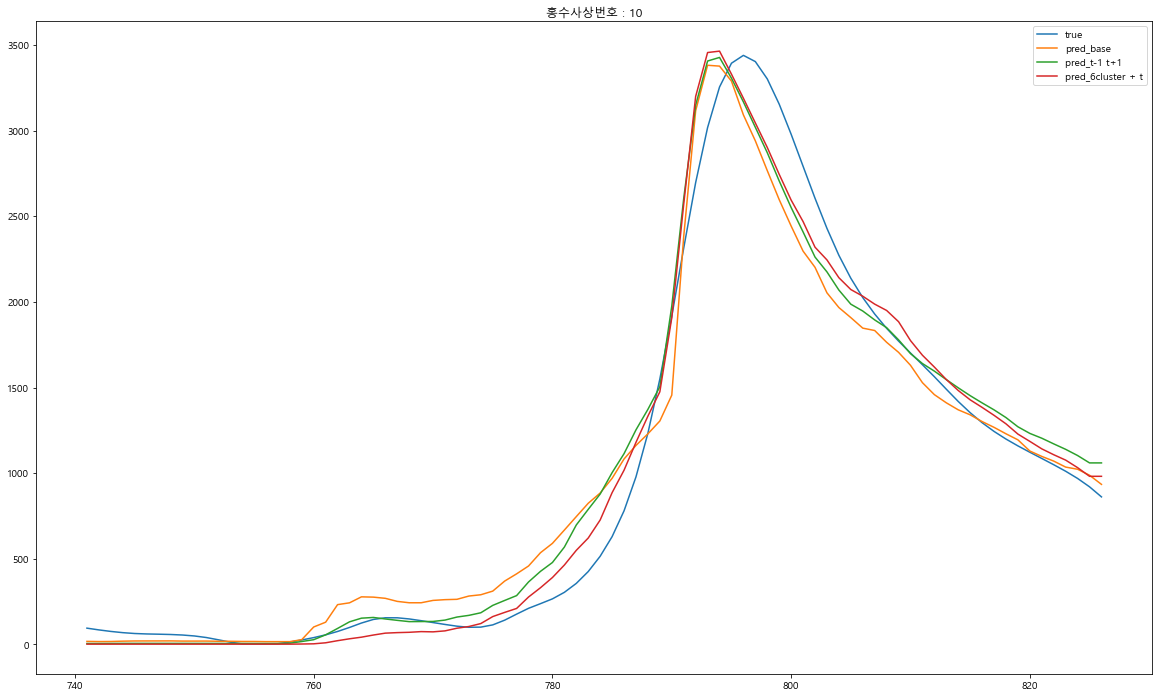

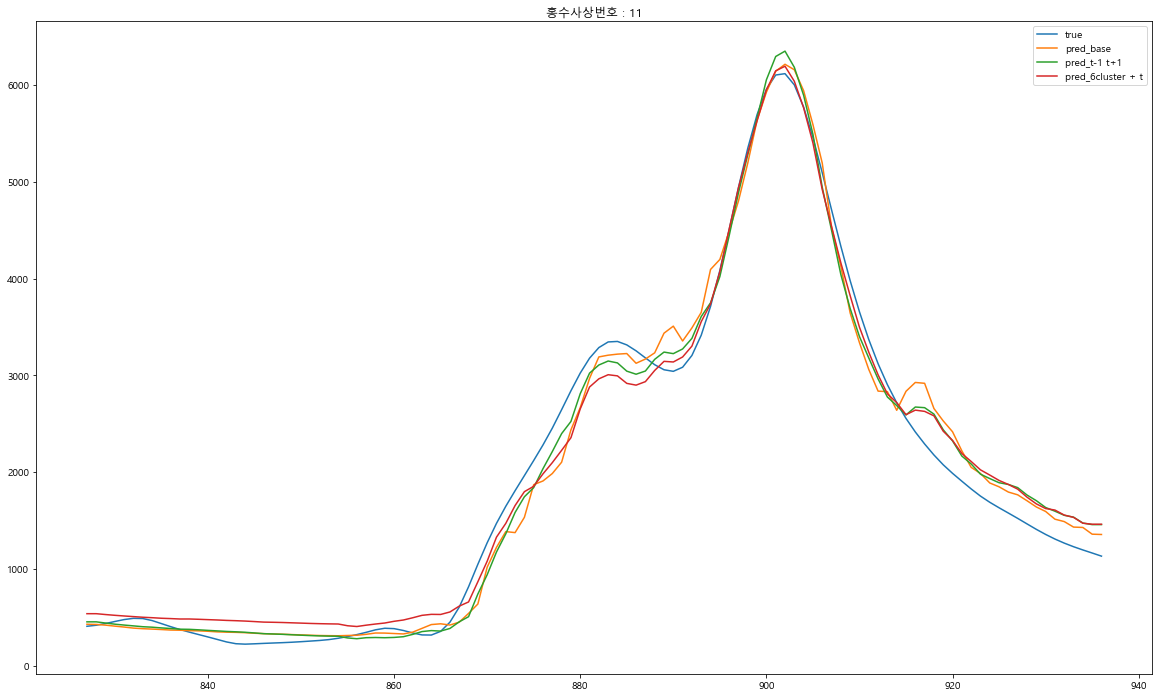

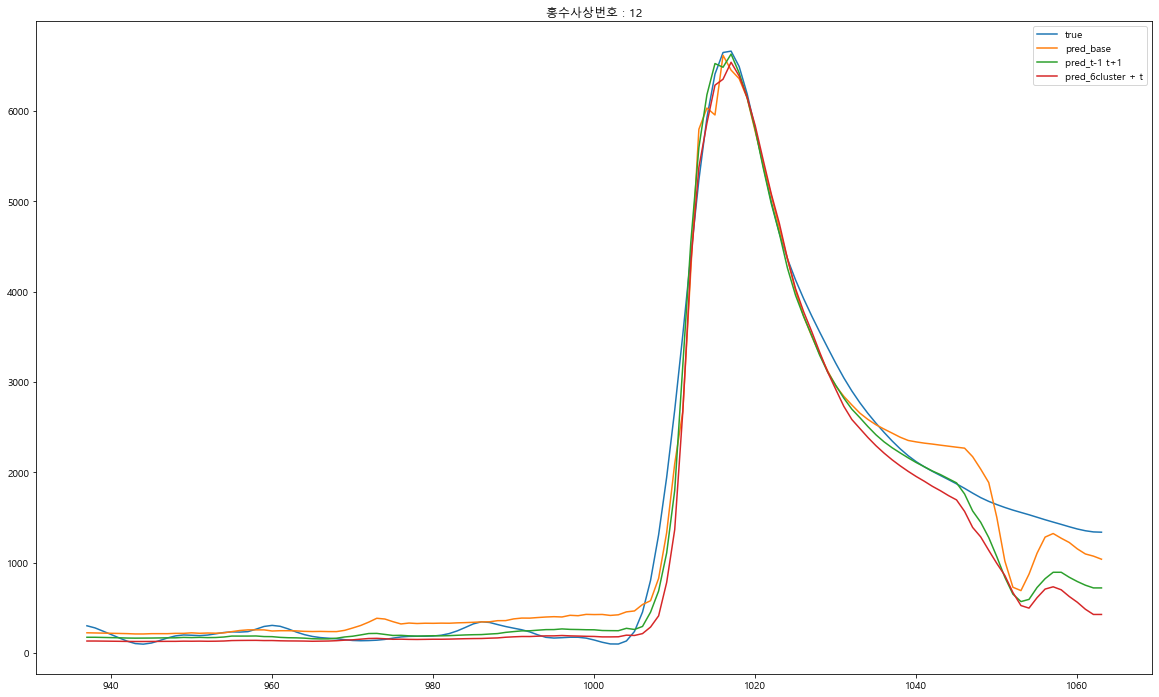

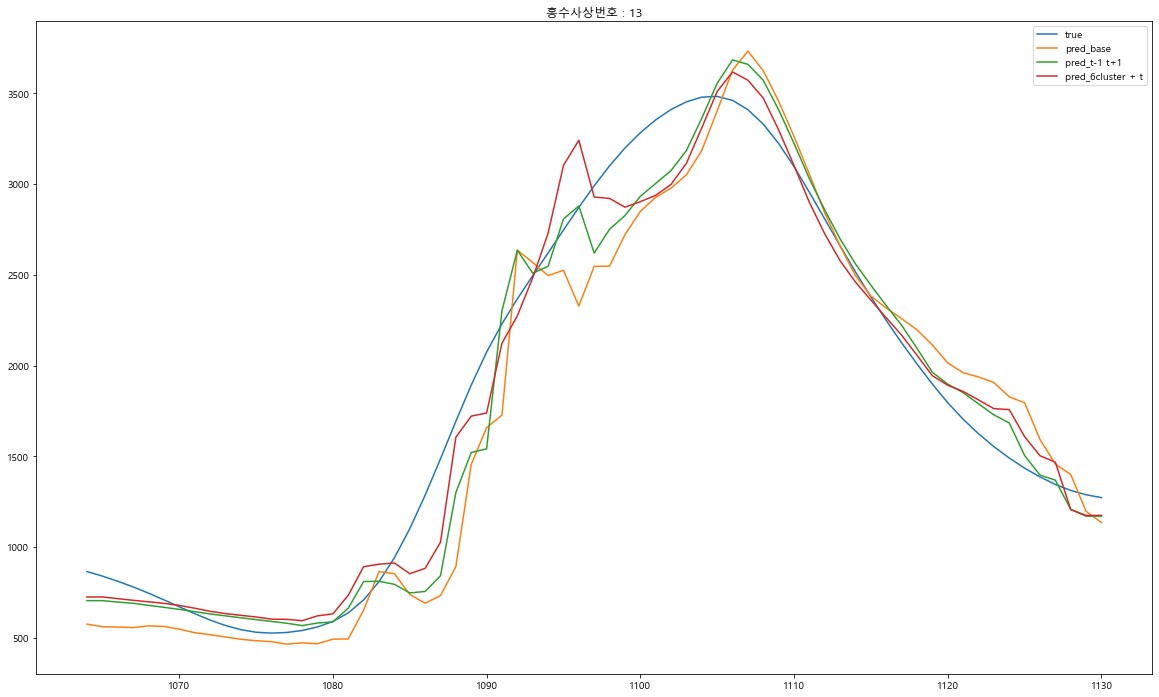

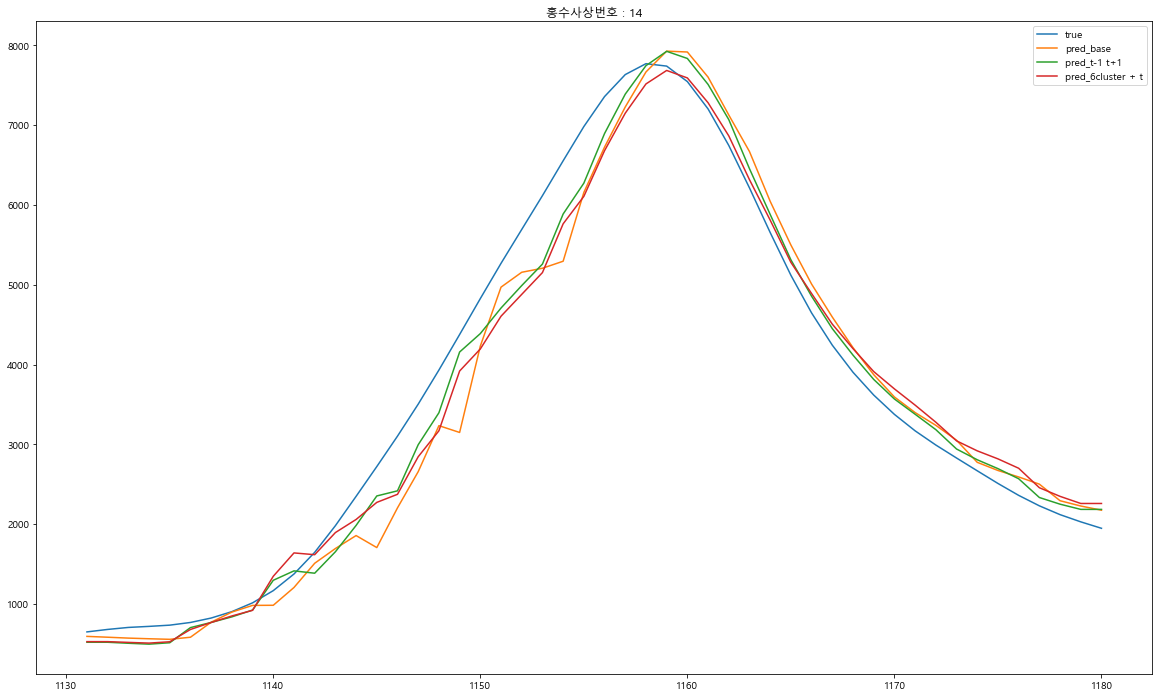

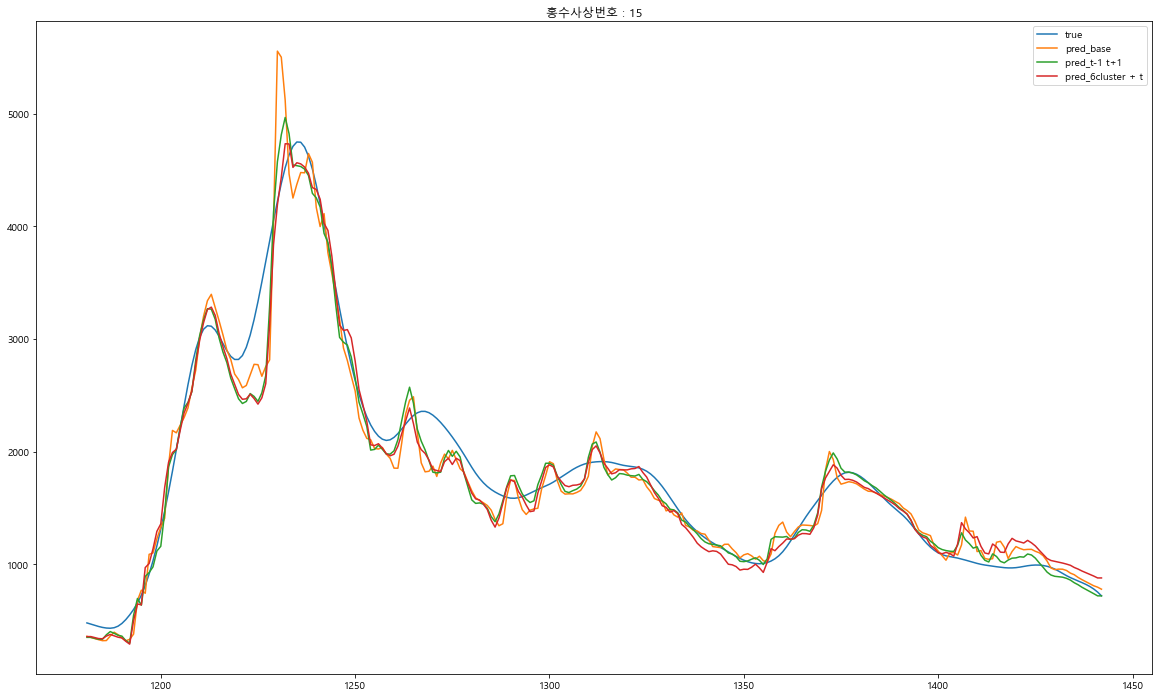

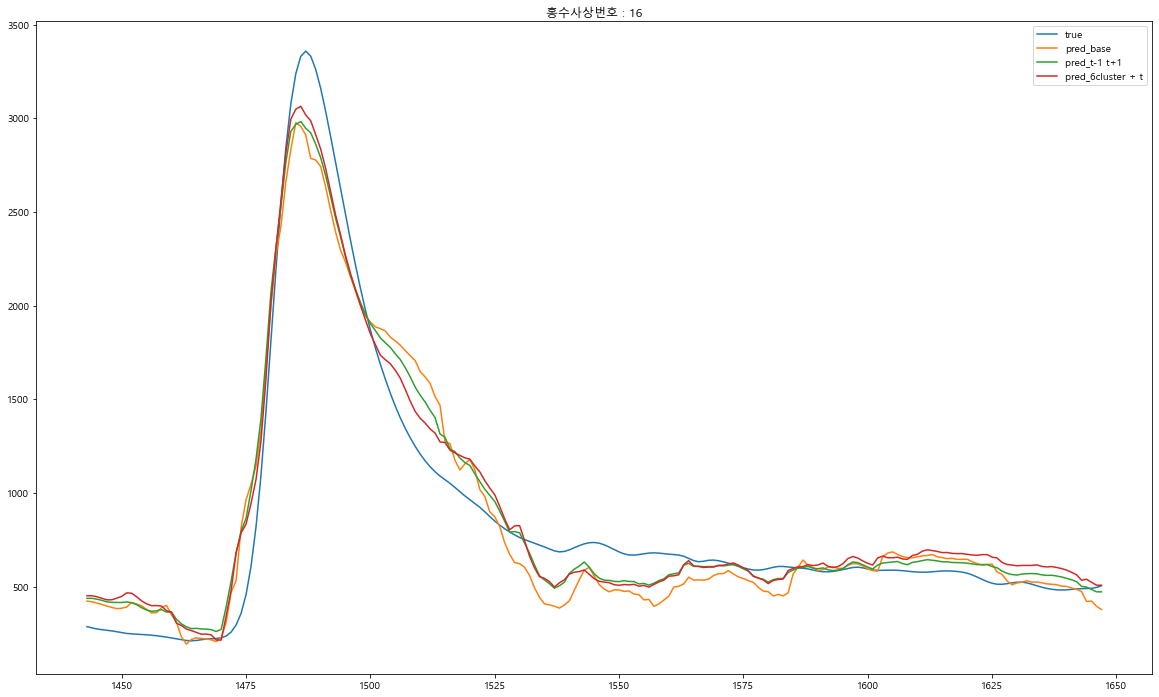

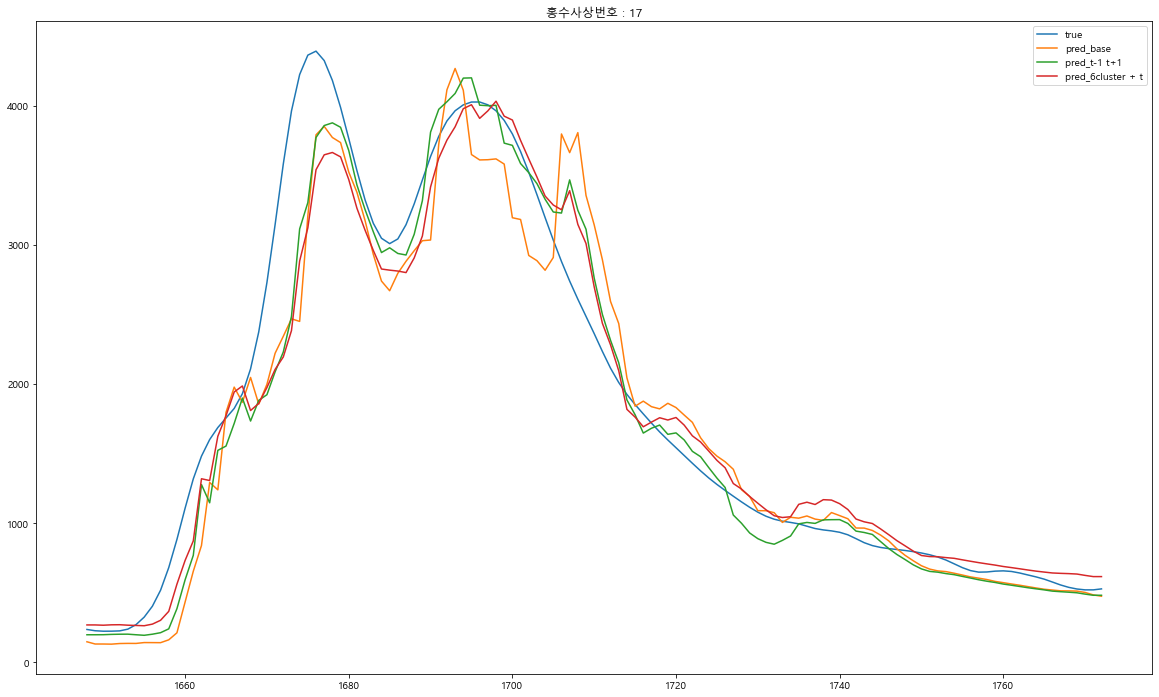

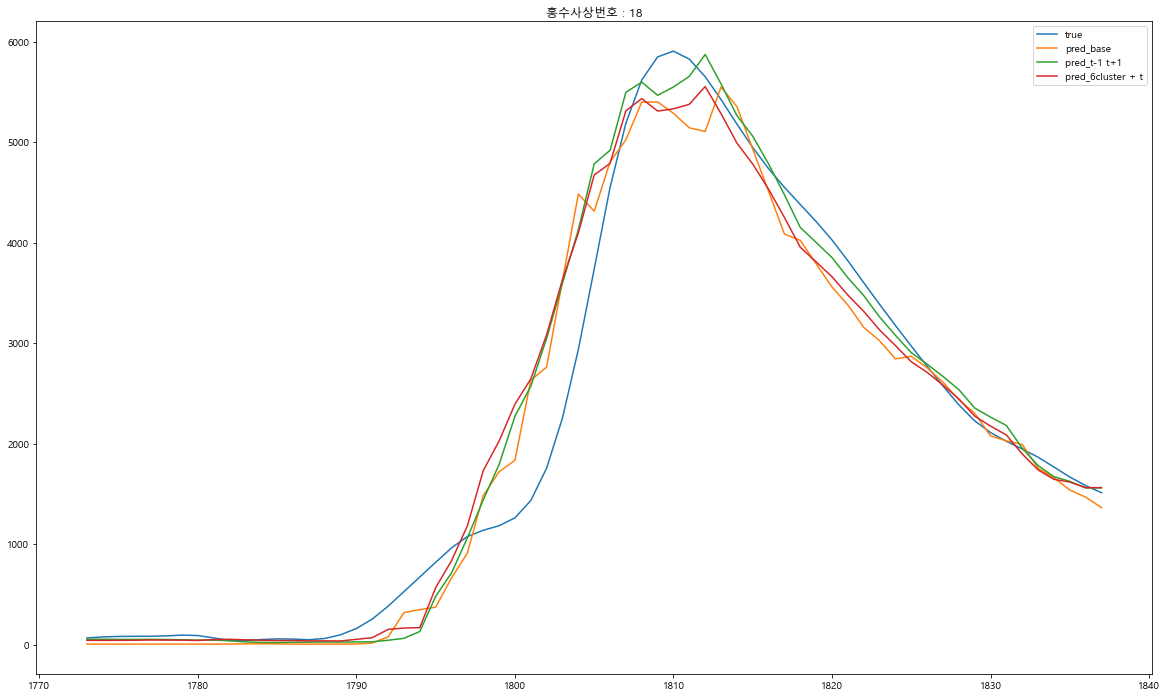

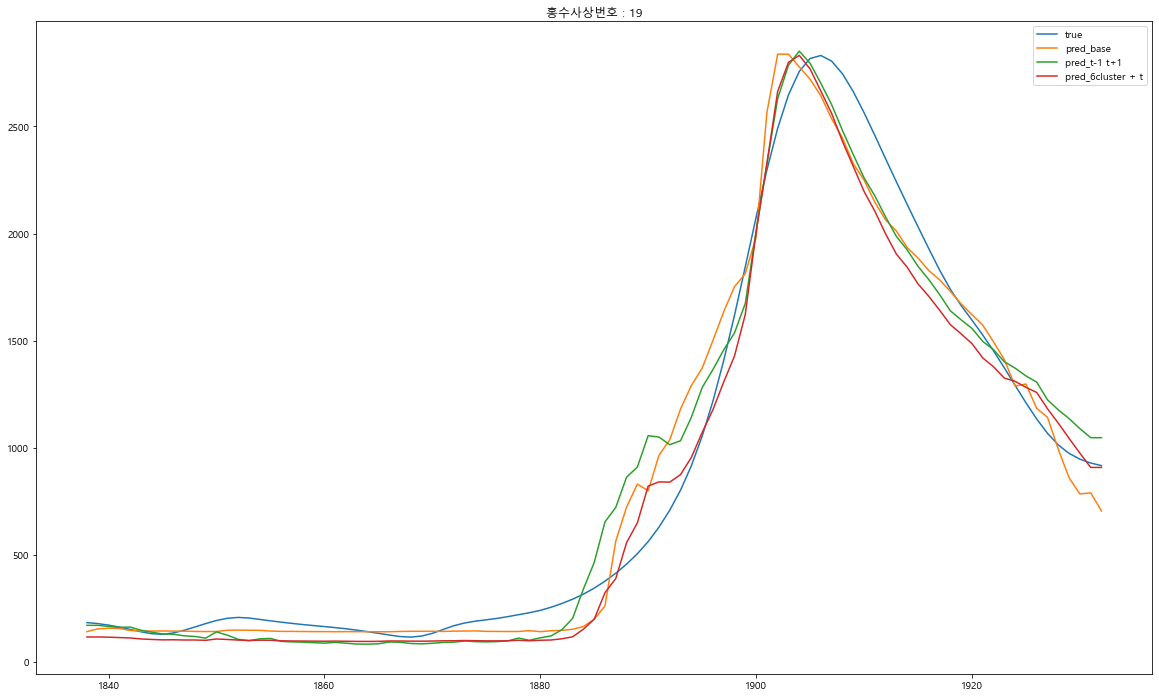

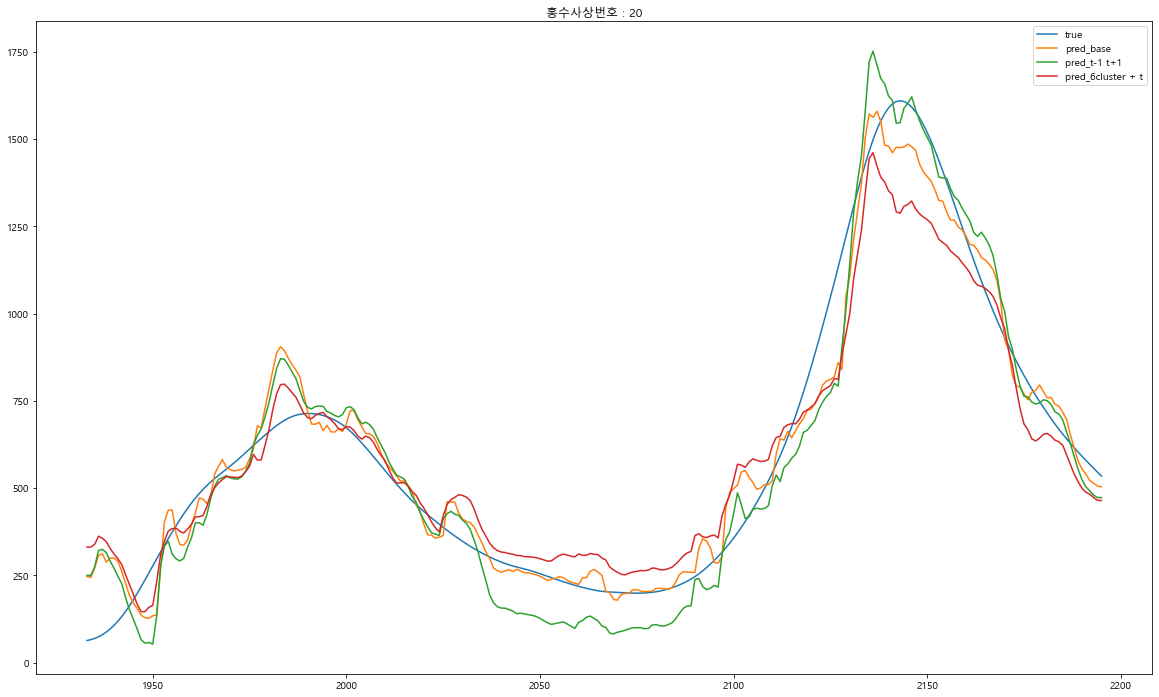

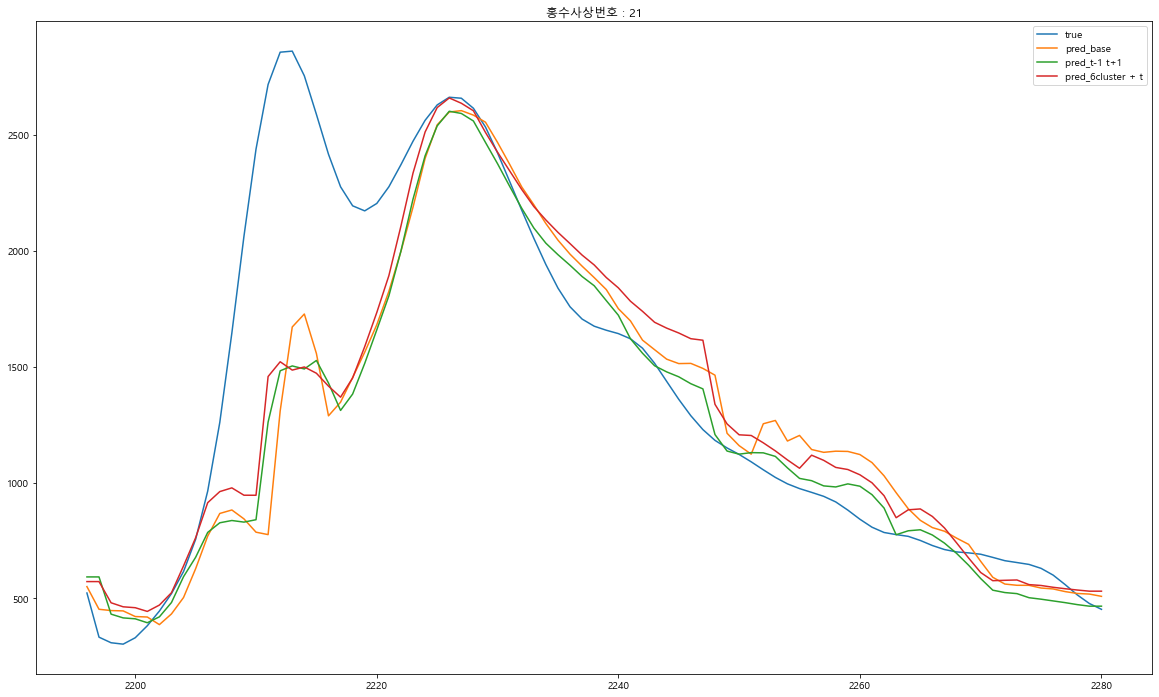

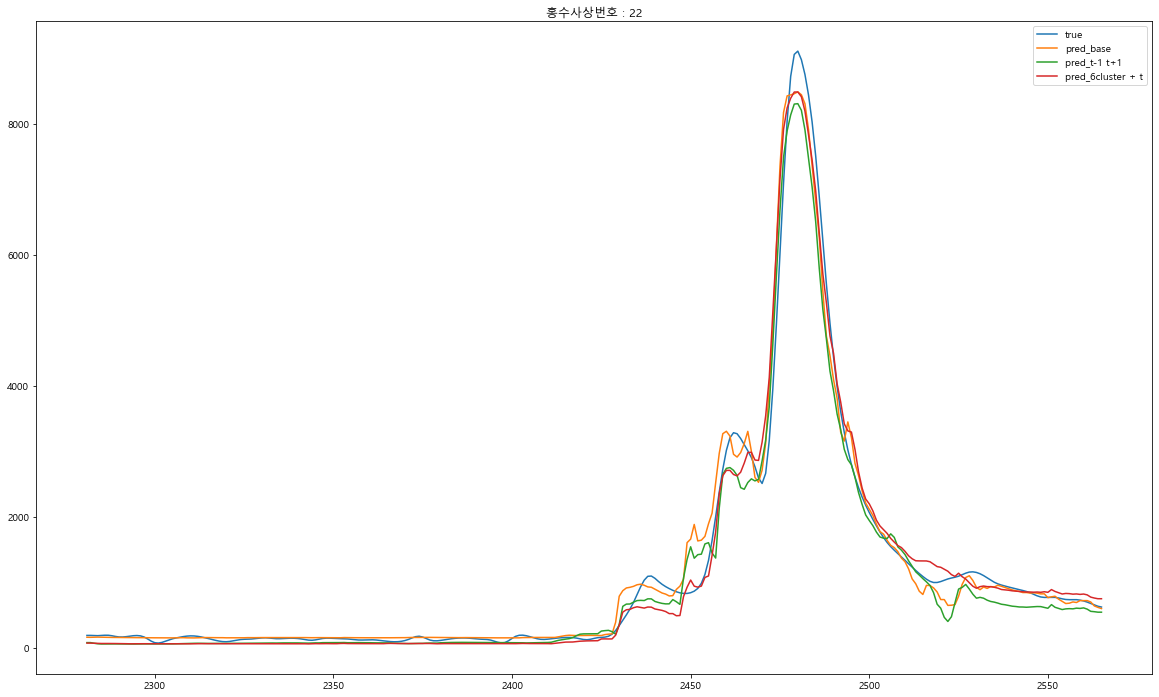

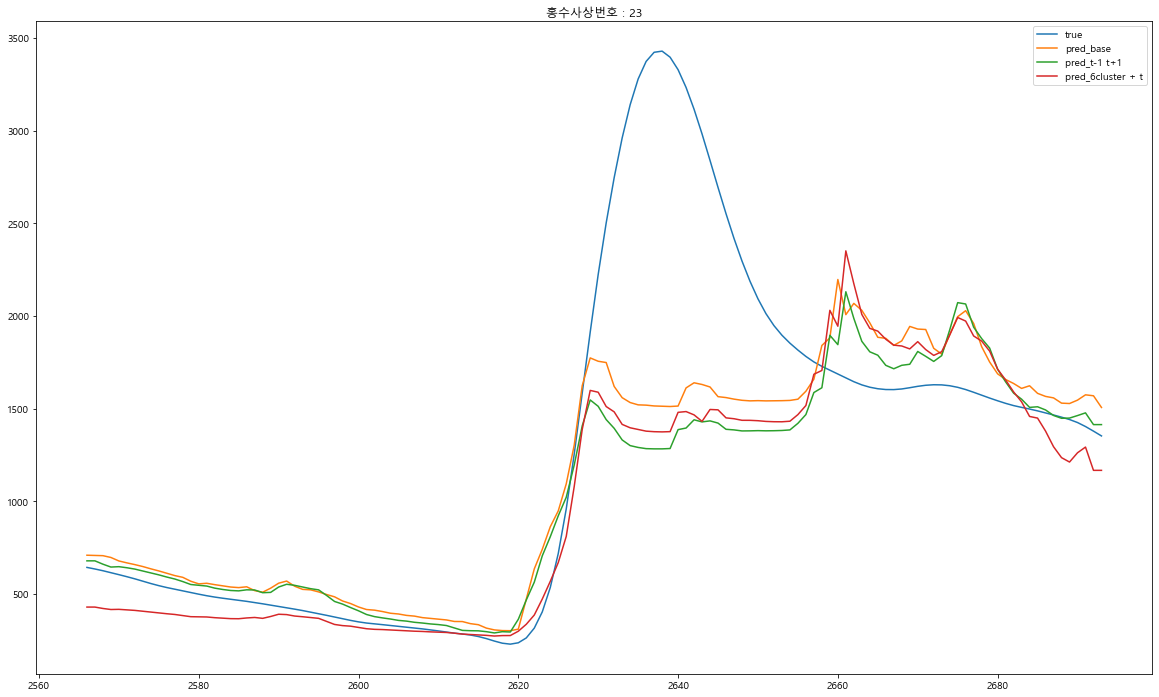

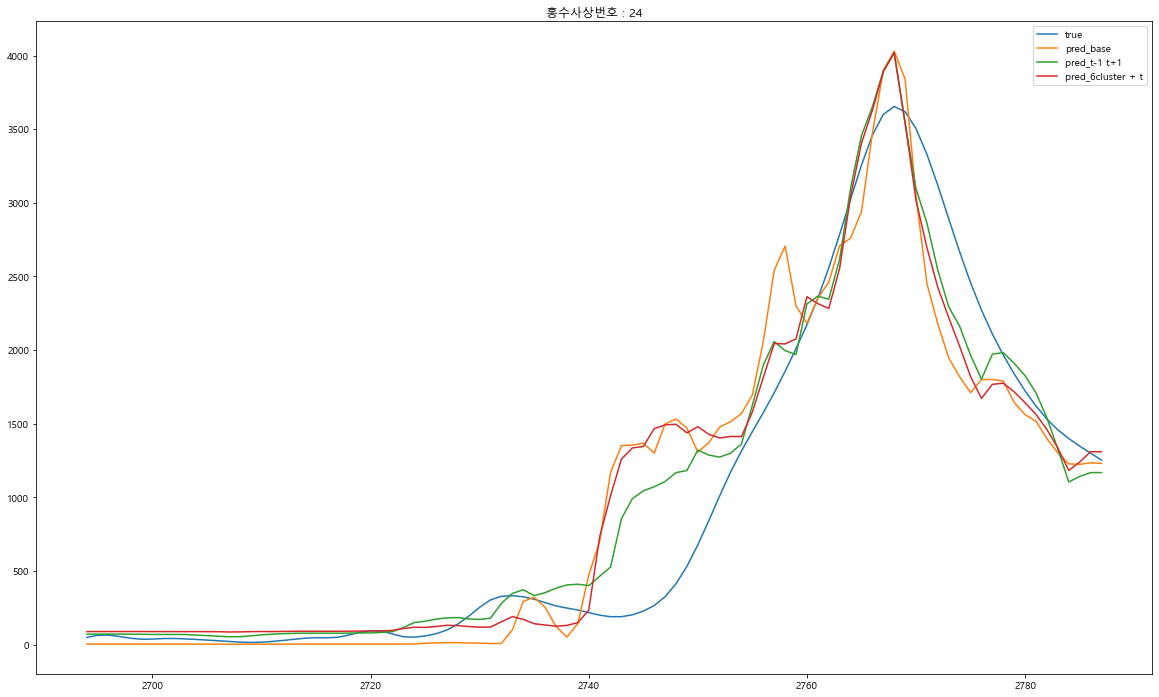

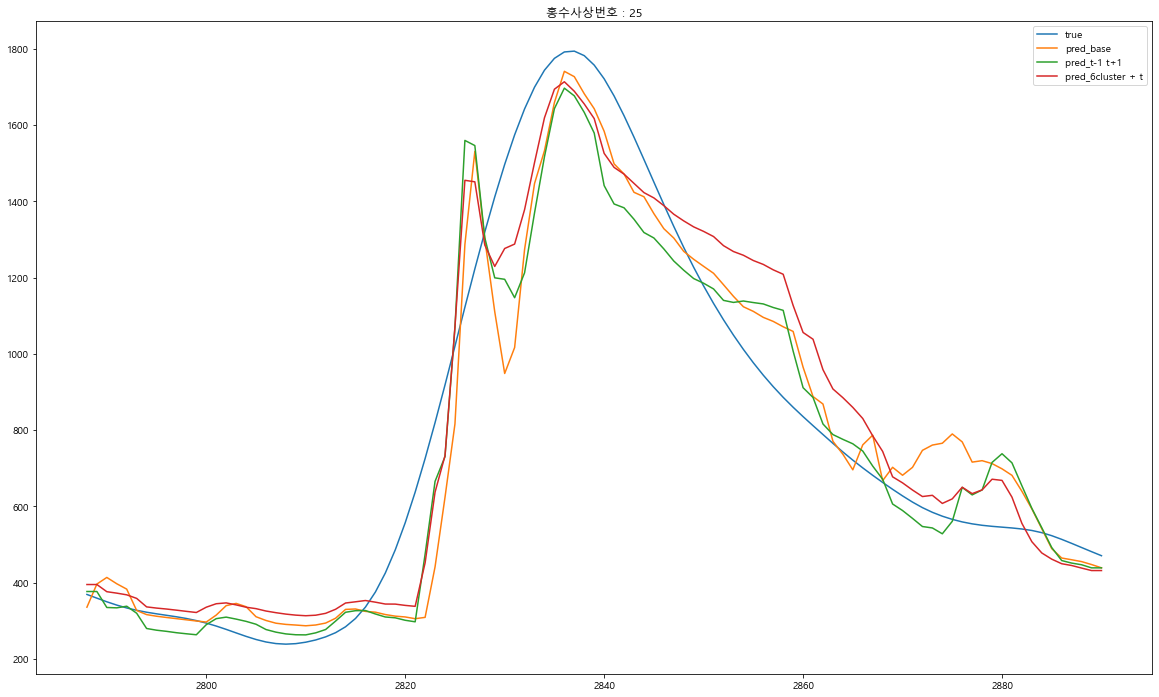

In [59]:
plot_hongsunum(predict_df, names=['base', 't-1 t+1', '6cluster + t'])